# 0. Dataset description

Data source: https://www.kaggle.com/rounakbanik/the-movies-dataset

These files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. 
The dataset consists of movies released on or before July 2017. 
Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.
This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

This dataset consists of the following files:
- movies_metadata.csv: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.
- keywords.csv: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.
- credits.csv: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.
- links.csv: The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.
- ratings.csv: all ratings for all movies

**Goal of the analysis:** try to predict movie's rating before its release (based on information, available before release)


# 1. Read data

In [327]:
import pandas as pd
from collections import Counter
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
pd.set_option('display.max_columns', 500)
import seaborn as sns
import timeit
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import random
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

## 1.1. Ratings data

Ratings data contains all ratings given by users. We will use this raw data to calculate movies' ratings at some specific time.

In [120]:
ratings = pd.read_csv("ratings.csv")

In [121]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [122]:
ratings["timestamp_ts"] = [datetime.utcfromtimestamp(ts) for ts in ratings["timestamp"]]

In [123]:
ratings["timestamp_dateid"] = [ts.year*10000 + ts.month*100 + ts.day for ts in ratings["timestamp_ts"]]

In [124]:
ratings["timestamp_month"] = [int(math.modf(d/100)[1]) for d in ratings["timestamp_dateid"]]

In [125]:
ratings.head()

,userId,movieId,rating,timestamp,timestamp_ts,timestamp_dateid,timestamp_month
0,1,110,1.0,1425941529,2015-03-09 22:52:09,20150309,201503
1,1,147,4.5,1425942435,2015-03-09 23:07:15,20150309,201503
2,1,858,5.0,1425941523,2015-03-09 22:52:03,20150309,201503
3,1,1221,5.0,1425941546,2015-03-09 22:52:26,20150309,201503
4,1,1246,5.0,1425941556,2015-03-09 22:52:36,20150309,201503


Here we aggregate data by movie and month - this way we will be able to easily calculate the rating obtained by specific movie at some point in time.

In [126]:
ratings_agr_by_movie_and_month = ratings[['movieId', 'timestamp_month', 'rating']].groupby(['movieId', 'timestamp_month']).agg({'sum', 'count'})

In [127]:
print(ratings_agr_by_movie_and_month.head())
print(ratings_agr_by_movie_and_month.shape)

                        rating        
                         count     sum
movieId timestamp_month               
1       199601               2     8.0
        199602              17    77.0
        199603             108   496.0
        199604             614  2691.0
        199605            1957  8005.0
(1532078, 2)


## 1.2. Metadata about movies (file movies_metadata.csv)


### Load data:

In [141]:
movies_metadata = pd.read_csv("movies_metadata.csv", low_memory=False)

In [142]:
def int_or_zero(value):
  try:
    int(value)
    return int(value)
  except ValueError:
    return 0

In [143]:
movies_metadata['id'] = [int_or_zero(i) for i in list(movies_metadata['id'].values)]

In [144]:
movies_metadata_init = movies_metadata.copy() # for further use


### Observe columns:


In [145]:
movies_metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
5,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
6,False,NaN,58000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,6.677277,/jQh15y5YB7bWz1NtffNZmRw0s9D.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0
7,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,45325,tt0112302,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",2.561161,/sGO5Qa55p7wTu7FJcX4H4xIVKvS.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Original Bad Boys.,To

In [146]:
# Release date: keep only movies released after rating system started 

def datetime_or_19000101(s):
  try:
    datetime.strptime(str(s), '%Y-%m-%d')
    return datetime.strptime(str(s), '%Y-%m-%d')
  except ValueError:
    return datetime.strptime(str('1900-01-01'), '%Y-%m-%d')

In [147]:
movies_metadata['release_date_datetime'] = [datetime_or_19000101(s) for s in movies_metadata['release_date']]
movies_metadata['release_date_dateid'] = [ts.year*10000 + ts.month*100 + ts.day for ts in movies_metadata['release_date_datetime']]

In [148]:
movies_metadata = movies_metadata[movies_metadata['release_date_dateid'] > ratings['timestamp_dateid'].min()]
movies_metadata.shape

(27289, 26)


### Movies metadata: status

We have 'status' column, which has the following distribution:


In [149]:
movies_metadata['status'].value_counts()

Released           26973
Rumored              128
Post Production       95
In Production         19
Planned               13
Canceled               1
Name: status, dtype: int64


We will leave only released movies (not rumored, planned, etc)


In [150]:
movies_metadata = movies_metadata[movies_metadata['status'] == 'Released']
movies_metadata = movies_metadata.set_index(['id'])
print(movies_metadata.shape)

(26973, 25)



### Movies metadata: number of votes

Now we will check the number of votes - we want to have a substantial number so that to have vote estimation based on enough number of votes. Let's check the distribution:


In [151]:
print("Number of votes distribution (decentiles): ")
print(movies_metadata['vote_count'].quantile(np.linspace(0,1,11)))

Number of votes distribution (decentiles): 
0.0        0.0
0.1        1.0
0.2        3.0
0.3        5.0
0.4        8.0
0.5       12.0
0.6       20.0
0.7       35.0
0.8       76.0
0.9      267.8
1.0    14075.0
Name: vote_count, dtype: float64


In [156]:
movies_metadata['budget_float'] = [float(i) for i in movies_metadata['budget'].values]

movies_metadata['vote_count_qcut_10'] = pd.qcut(movies_metadata['vote_count'], 10)
print(movies_metadata.groupby(['vote_count_qcut_10'])['budget_float'].mean())

vote_count_qcut_10
(-0.001, 1.0]       7.365932e+04
(1.0, 3.0]          1.244146e+05
(3.0, 5.0]          2.681294e+05
(5.0, 8.0]          3.089500e+05
(8.0, 12.0]         5.078719e+05
(12.0, 20.0]        1.059958e+06
(20.0, 35.0]        1.613024e+06
(35.0, 76.0]        3.426800e+06
(76.0, 267.8]       9.860336e+06
(267.8, 14075.0]    4.611773e+07
Name: budget_float, dtype: float64


In [139]:
movies_metadata.sort_values(by = 'vote_count', ascending = False)

,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_date_datetime,release_date_dateid
id,,,,,,,,,,,,,,,,,,,,,,,,,
27205,False,NaN,160000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",http://inceptionmovie.warnerbros.com/,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",29.108149,/qmDpIHrmpJINaRKAfWQfftjCdyi.jpg,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2010-07-14,8.255328e+08,148.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Your mind is the scene of the crime.,Inception,False,8.1,14075.0,2010-07-14,20100714
155,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,123.167259,/1hRoyzDtpgMU7Dz4JF22RANzQO7.jpg,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2008-07-16,1.004558e+09,152.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Why So Serious?,The Dark Knight,False,8.3,12269.0,2008-07-16,20080716
19995,False,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",185.070892,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2.787965e+09,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,False,7.2,12114.0,2009-12-10,20091210
24428,False,"{'id': 86311, 'name': 'The Avengers Collection...",220000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://marvel.com/avengers_movie/,tt0848228,en,The Avengers,When an unexpected enemy emerges and threatens...,89.887648,/cezWGskPY5x7GaglTTRN4Fugfb8.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-04-25,1.519558e+09,143.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Some assembly required.,The Avengers,False,7.4,12000.0,2012-04-25,20120425
293660,False,"{'id': 448150, 'name': 'Deadpool Collection', ...",58000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.foxmovies.com/movies/deadpool,tt1431045,en,Deadpool,Deadpool tells the origin story of former Spec...,187.860492,/inVq3FRqcYIRl2la8iZikYYxFNR.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2016-02-09,7.831130e+08,108.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Witness the beginning of a happy ending,Deadpool,False,7.4,11444.0,2016-02-09,20160209
157336,False,NaN,165000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",http://www.interstellarmovie.net/,tt0816692,en,Interstellar,Interstellar chronicles the adventures of a gr...,32.213481,/nBNZadXqJSdt05SHLqgT0HuC5Gm.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",2014-11-05,6.751200e+08,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Mankind was born on Earth. It was never meant ...,Interstellar,False,8.1,11187.0,2014-11-05,20141105
68718,False,NaN,100000000,"[{'id': 18, 'name': 'Drama'}, {'id': 37, 'name...",http://unchainedmovie.com/,tt1853728,en,Django Unchained,"With the help of a German bounty hunter, a fre...",19.785025,/5WJnxuw41sddupf8cwOxYftuvJG.jpg,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-25,4.253682e+08,165.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"Life, liberty and the pursu


A lot of movies have small number of votes, so the vote average can be volatile. 
We will remove such cases and leave only movies with more than 50 votes.


In [157]:
movies_metadata = movies_metadata[movies_metadata['vote_count'] > 50]
movies_metadata.shape

(6683, 27)


### Movies metadata: belongs to collection

This column shows if movie belongs to any collection. We will recode it to 1/0 variable

In [158]:
movies_metadata['belongs_to_collection_tf'] = 1
movies_metadata.loc[movies_metadata['belongs_to_collection'].isna(), 'belongs_to_collection_tf'] = 0

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Movies which belong to some collection have higher rating, on average:

In [159]:
movies_metadata.groupby(['belongs_to_collection_tf'])['vote_average'].mean()

belongs_to_collection_tf
0    6.275531
1    6.065373
Name: vote_average, dtype: float64

### Movies metadata: multiple response columns (genres, production companies, production countries, spoken languages)

There are several columns with multiple response, so that for each movie several options are available. They are saved as lists of dictionaries and contain information about genres, production companies, production countries, spoken languages.

We would like to recode them into 'wide' form, so that a separate column codes a single option. We will also need to observe the statistics and be able to remove some rare options. This will be done using the following functions: 


In [161]:
def create_df_movieid_item_for_every_item(d_id_item, name_of_item_element):

    # Create dictionary with movie id and item (we use dictionary for speed reasons)
    
    id_item_dict = dict()

    id_item_dict_key = 0

    for movie_i in list(d_id_item.index):
        for item_i in eval(d_id_item.loc[movie_i][0]):
            id_item_dict[id_item_dict_key] = {'id': movie_i, 
                                              'name': item_i[name_of_item_element]}
            id_item_dict_key = id_item_dict_key + 1

    # Convert dictionary into datafram

    id_item_df = pd.DataFrame.from_dict(id_item_dict, orient = "index")
    id_item_df = id_item_df.drop_duplicates()
    id_item_df['value'] = 1
            
    return id_item_df

def create_wide_df_movieid_item(df_long, column_to_convert):
    
    df_wide = df_long.pivot(index = 'id', columns = column_to_convert, values = "value")
    df_wide = pd.DataFrame(df_wide.to_records())
    df_wide = df_wide.fillna(0)
    
    return df_wide

def merge_full_dataset_with_wide(df_wide, item_name):

    # Merge wide representation of item with full movies database

    result_df = movies_metadata.merge(df_wide, left_index = True, right_index = True, how = "left")

    item_columns = result_df.columns[np.array([bool(re.search(item_name + '_', s)) for s in result_df.columns])]
    item_columns = [s for s in item_columns if s != item_name + '_id']

    result_df[item_columns] = result_df[item_columns].fillna(0)
  
    return result_df

#### Movies metadata: multiple response columns. Genres

In [162]:
genres = movies_metadata[['genres']].drop_duplicates()
genres_long = create_df_movieid_item_for_every_item(genres, 'name')

# Check if we need to delete any genres

print(genres_long.groupby('name')['value'].count().sort_values(ascending = False))

name
Drama              623
Action             561
Comedy             500
Thriller           499
Adventure          464
Fantasy            382
Science Fiction    363
Family             290
Crime              270
Romance            269
Horror             245
Animation          238
Mystery            218
History             99
Music               86
War                 83
TV Movie            50
Western             48
Documentary         37
Foreign              2
Name: value, dtype: int64



We will delete foreign genre due to small number of movies in it, and then convert data to wide format and merge with initial dataframe


In [163]:
genres_long = genres_long[genres_long['name'] != 'Foreign']
genres_long = genres_long.reset_index()

# Convert long table with genres to wide and rename columns in a tidy way

genres_wide = create_wide_df_movieid_item(df_long = genres_long, column_to_convert = 'name')
genres_wide.columns = ["genre_" + s.replace(" ", "") for s in genres_wide.columns]

# Merge wide form with full dataset

movies_metadata = merge_full_dataset_with_wide(df_wide = genres_wide, item_name = "genre")

# Remove unnecessary variables    
    
del genres_wide, genres_long, genres

#### Movies metadata: multiple response columns. Production companies

In [164]:
production_companies = movies_metadata[['production_companies']].drop_duplicates()

production_companies_long = create_df_movieid_item_for_every_item(production_companies, 'id')

# Check if we need to delete any production companies

print(production_companies_long.groupby('name')['value'].count().sort_values(ascending = False))

name
6194     281
33       257
4        189
306      179
5358     177
5        145
12       127
7295     111
79        93
9195      87
2         84
14        82
8411      81
508       77
694       75
27        74
3823      70
288       70
1632      68
43        65
444       63
441       62
491       61
10163     60
9349      60
856       56
7405      52
711       50
83        49
10104     48
        ... 
25250      1
25345      1
25406      1
25434      1
25462      1
24992      1
24991      1
24972      1
24859      1
24630      1
24644      1
24646      1
24647      1
24648      1
24785      1
24845      1
24846      1
24851      1
24884      1
24970      1
24885      1
24899      1
24900      1
24901      1
24903      1
24904      1
24923      1
24933      1
24934      1
16558      1
Name: value, Length: 7222, dtype: int64



We will leave only companies with at least 50 movies


In [165]:
production_companies_count = production_companies_long.groupby('name')['value'].count()
print("Share of movies done by companies with at least 50 movies is " + str(production_companies_count[production_companies_count > 50].sum()/production_companies_count.sum()) +
     ", number of such companies is " + str(len(production_companies_count[production_companies_count > 50])))

Share of movies done by companies with at least 50 movies is 0.14098377129076017, number of such companies is 27


In [166]:
production_companies_long = production_companies_long[production_companies_long['name'].isin(list(production_companies_count[production_companies_count > 50].index))]
production_companies_long = production_companies_long[['id', 'name', 'value']]
production_companies_long = production_companies_long.reset_index()

# Convert long table with production companies to wide and rename columns in a tidy way

production_companies_wide = create_wide_df_movieid_item(df_long = production_companies_long, 
                                                       column_to_convert = 'name')
production_companies_wide.columns = ["prod_comp_" + s.replace(" ", "") for s in production_companies_wide.columns]

# Merge wide form with full dataset

movies_metadata = merge_full_dataset_with_wide(df_wide = production_companies_wide, item_name = "prod_comp")

# Remove unnecessary variables    
    
del production_companies_wide, production_companies_long, production_companies, production_companies_count

#### Movies metadata: multiple response columns. Production countries

In [167]:
production_countries = movies_metadata[['production_countries']].drop_duplicates()
production_countries_long = create_df_movieid_item_for_every_item(production_countries, 'name')

# Check if we need to delete any production countries

print(production_countries_long.groupby('name')['value'].count().sort_values(ascending = False))

name
United States of America    340
France                      265
United Kingdom              248
Germany                     201
Canada                       90
Italy                        78
Belgium                      63
Spain                        60
Denmark                      48
Japan                        46
Sweden                       41
China                        39
Australia                    38
Netherlands                  36
Hong Kong                    32
Ireland                      31
Norway                       27
Czech Republic               27
Switzerland                  25
Luxembourg                   23
South Africa                 22
Hungary                      21
New Zealand                  20
Russia                       17
Mexico                       17
India                        17
Austria                      16
Romania                      16
Finland                      15
South Korea                  15
                           ... 
Aru

We will leave only countries with > 50 movies

In [168]:
production_countries_count = production_countries_long.groupby('name')['value'].count()
print("Share of movies done by countries with at least 50 movies is " + str(production_countries_count[production_countries_count > 50].sum()/production_countries_count.sum()) + 
     ", number of such countries is " + str(len(production_countries_count[production_countries_count > 50])))

Share of movies done by countries with at least 50 movies is 0.6212471131639723, number of such countries is 8


In [169]:
production_countries_long = production_countries_long[production_countries_long['name'].isin(list(production_countries_count[production_countries_count > 50].index))]
production_countries_long = production_countries_long[['id', 'name', 'value']]
production_countries_long = production_countries_long.reset_index()

# Convert long table with production countries to wide and rename columns in a tidy way

production_countries_wide = create_wide_df_movieid_item(df_long = production_countries_long, 
                                                       column_to_convert = 'name')
production_countries_wide.columns = ["prod_country_" + s.replace(" ", "") for s in production_countries_wide.columns]

# Merge wide form with full dataset

movies_metadata = merge_full_dataset_with_wide(df_wide = production_countries_wide, item_name = "prod_country")

# Remove unnecessary variables    
    
del production_countries_wide, production_countries_long, production_countries, production_countries_count

#### Movies metadata: multiple response columns. Spoken languages

In [170]:
spoken_languages = movies_metadata[['spoken_languages']].drop_duplicates()
spoken_languages_long = create_df_movieid_item_for_every_item(spoken_languages, 'iso_639_1')

# Check if we need to delete any production countries

print(spoken_languages_long.groupby('name')['value'].count().sort_values(ascending = False))

name
en    573
fr    260
de    191
es    158
ru    117
it    114
ja     87
zh     75
ar     72
pt     54
cn     45
la     43
pl     40
ko     38
sv     35
th     34
hi     31
hu     31
da     29
he     29
cs     25
tr     24
el     19
no     17
ro     16
nl     15
uk     15
ur     15
sr     14
fa     14
     ... 
my      2
bn      2
ce      2
co      2
sa      2
eo      2
iu      2
gl      2
ml      2
lt      2
km      2
jv      1
br      1
am      1
kk      1
be      1
wo      1
bm      1
ku      1
ln      1
gu      1
mr      1
st      1
ms      1
ny      1
mi      1
cr      1
oc      1
qu      1
nv      1
Name: value, Length: 92, dtype: int64


We will leave languages used in at least 100 movies

In [171]:
spoken_languages_count = spoken_languages_long.groupby('name')['value'].count()
print("Share of movies with languages used in least 100 movies is " + str(spoken_languages_count[spoken_languages_count > 100].sum()/spoken_languages_count.sum()) + 
     ", number of such languages is " + str(len(spoken_languages_count[spoken_languages_count > 100])))

Share of movies with languages used in least 100 movies is 0.5810032894736842, number of such languages is 6


In [172]:
spoken_languages_long = spoken_languages_long[spoken_languages_long['name'].isin(list(spoken_languages_count[spoken_languages_count > 100].index))]
spoken_languages_long = spoken_languages_long[['id', 'name', 'value']]
spoken_languages_long = spoken_languages_long.reset_index()

# Convert long table with production countries to wide and rename columns in a tidy way

spoken_languages_wide = create_wide_df_movieid_item(df_long = spoken_languages_long, 
                                                       column_to_convert = 'name')
spoken_languages_wide.columns = ["spoken_lang_" + s.replace(" ", "") for s in spoken_languages_wide.columns]

# Merge wide form with full dataset

movies_metadata = merge_full_dataset_with_wide(df_wide = spoken_languages_wide, item_name = "spoken_lang")

# Remove unnecessary variables    
    
del spoken_languages_wide, spoken_languages_long, spoken_languages, spoken_languages_count


### Movies metadata: budget

Budget vs vote scatterplot does not show strong correlation between these two variables: looks like lower budget movies have higher variability in votes, while higher budget movies are closer to the average (showed by red line). Indeed, the correlation between budget and votes is very small:

In [173]:
np.corrcoef([float(i) for i in movies_metadata['budget'].values], 
            [float(i) for i in movies_metadata['vote_average'].values])[0,1]

0.009787319082042096

Text(0, 0.5, 'Vote average')

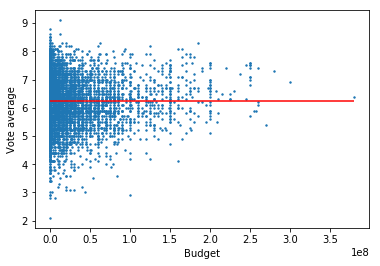

In [174]:
plt.figure()
plt.scatter(x = [float(i) for i in movies_metadata['budget'].values], 
            y = [float(i) for i in movies_metadata['vote_average'].values],
           s = 2)
plt.hlines(y = movies_metadata['vote_average'].mean(),
          xmin = min([float(i) for i in movies_metadata['budget'].values]),
          xmax = max([float(i) for i in movies_metadata['budget'].values]),
          colors = 'red')
plt.xlabel('Budget')
plt.ylabel('Vote average')


However, there are a lot of movies with zero budget - probably missing data.


In [175]:
print("Share of movies with zero budget is " + str(movies_metadata.loc[movies_metadata['budget_float'] == 0, 'budget_float'].count()/movies_metadata['budget_float'].count()))

print("However correlation for non zero values is also very low " + str(np.corrcoef([float(i) for i in movies_metadata.loc[movies_metadata['budget_float'] > 0, 'budget'].values], 
            [float(i) for i in movies_metadata.loc[movies_metadata['budget_float'] > 0, 'vote_average'].values])[0,1]))

Share of movies with zero budget is 0.39218913661529253
However correlation for non zero values is also very low 0.03120562954129589


Spliting budget into groups does not show substantial difference in movies evaluation: neither mean, nor deviation:

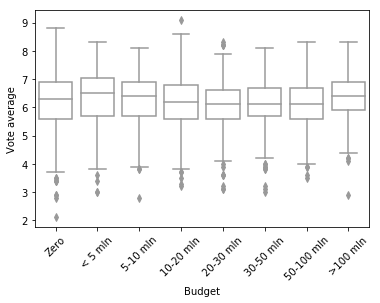

In [176]:
movies_metadata['budget_float_group'] = ''
movies_metadata.loc[movies_metadata['budget_float'] == 0, 'budget_float_group'] = 'Zero'
movies_metadata.loc[(movies_metadata['budget_float'] > 0) & (movies_metadata['budget_float'] < 5000000), 'budget_float_group'] = '< 5 mln'
movies_metadata.loc[(movies_metadata['budget_float'] >= 5000000) & (movies_metadata['budget_float'] < 10000000), 'budget_float_group'] = '5-10 mln'
movies_metadata.loc[(movies_metadata['budget_float'] >= 10000000) & (movies_metadata['budget_float'] < 20000000), 'budget_float_group'] = '10-20 mln'
movies_metadata.loc[(movies_metadata['budget_float'] >= 20000000) & (movies_metadata['budget_float'] < 30000000), 'budget_float_group'] = '20-30 mln'
movies_metadata.loc[(movies_metadata['budget_float'] >= 30000000) & (movies_metadata['budget_float'] < 50000000), 'budget_float_group'] = '30-50 mln'
movies_metadata.loc[(movies_metadata['budget_float'] >= 50000000) & (movies_metadata['budget_float'] < 100000000), 'budget_float_group'] = '50-100 mln'
movies_metadata.loc[(movies_metadata['budget_float'] >= 100000000), 'budget_float_group'] = '>100 mln'


p = sns.boxplot(x = "budget_float_group", y = "vote_average", data = movies_metadata,
                 order = ['Zero', '< 5 mln', '5-10 mln', '10-20 mln', '20-30 mln','30-50 mln', '50-100 mln', '>100 mln'],
                 color = 'white')
p.set(xlabel='Budget', ylabel='Vote average')
plt.xticks(rotation=45)
plt.show()

del p


### Movies metadata: release date

#### Release year

Movie evaluation depends heavily on the year of release: up to 1920s the annual averages are volatile because of the small number of movies, but after that there is a clear downward trend (red line shows average value). 

Text(0, 0.5, 'Vote average')

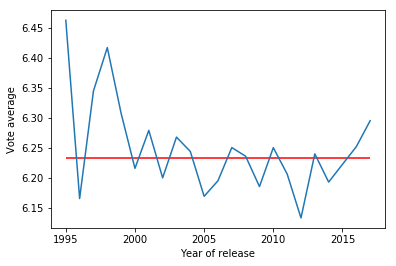

In [177]:
movies_metadata['release_year'] = [float(str(s)[:4]) for s in movies_metadata['release_date']]

vote_avg_by_release_year = movies_metadata.groupby('release_year')['vote_average'].mean()

plt.figure()
plt.plot(vote_avg_by_release_year)
plt.hlines(y = movies_metadata['vote_average'].mean(),
          xmin = min(vote_avg_by_release_year.index),
          xmax = max(vote_avg_by_release_year.index),
          colors = 'red')
plt.xlabel('Year of release')
plt.ylabel('Vote average')

The reason for such trend is presumably not that movies are getting worse, but that more recent movies get into sample, while out of old movies only the best ones are evaluated. It is supported by the fact that number of movies in the dataset gets higher with years

Text(0, 0.5, 'Number of movies evaluated')

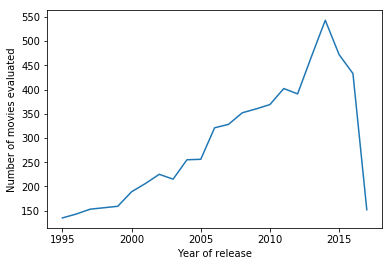

In [178]:
n_movies_by_release_year = movies_metadata.groupby('release_year')['vote_average'].count()

plt.figure()
plt.plot(n_movies_by_release_year)
plt.xlabel('Year of release')
plt.ylabel('Number of movies evaluated')

In [179]:
ratings['timestamp_year'] = [ts.year for ts in ratings['timestamp_ts']]

Ratings are obtained starting from 1995, but the number is substantial starting from 1996. 

In [180]:
ratings.groupby(['timestamp_year'])['movieId'].count()

timestamp_year
1995          4
1996    1733263
1997     763932
1998     329720
1999    1231263
2000    2034030
2001    1239718
2002     910659
2003    1079511
2004    1202081
2005    1850589
2006    1211577
2007    1096103
2008    1211067
2009     993934
2010     983023
2011     835260
2012     793710
2013     634778
2014     586094
2015    1913720
2016    2094961
2017    1295292
Name: movieId, dtype: int64

As soon as the goal of the analysis is to evaluate new movies, we want to evaluate only movies which were released when the rating system was on air already. That is why we will remove movies made before 1996 from sample.

In [181]:
movies_metadata = movies_metadata[movies_metadata['release_year'] >= 1996]

del vote_avg_by_release_year, n_movies_by_release_year

#### Release month

Month of release also shows some interesting patterns: movies with highest evaluations are released in December, and also high values are observed for May and September. As for December, it is explained by the Christmas period - studios try to release movies in this period of time to get more people in the cinema. May is another month for blockbuster kind of movies release, while September is the start of serious awards campaign like Oscar, etc.

Text(0, 0.5, 'Vote average')

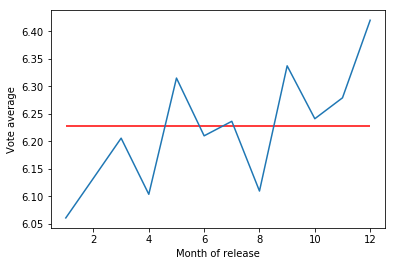

In [191]:
movies_metadata['release_month'] = pd.DatetimeIndex(movies_metadata['release_date_datetime']).month

vote_avg_by_release_month = movies_metadata.groupby('release_month')['vote_average'].mean()

plt.figure()
plt.plot(vote_avg_by_release_month)
plt.hlines(y = movies_metadata['vote_average'].mean(),
          xmin = min(vote_avg_by_release_month.index),
          xmax = max(vote_avg_by_release_month.index),
          colors = 'red')
plt.xlabel('Month of release')
plt.ylabel('Vote average')

So we will add respective categorical features:

In [183]:
movies_metadata['release_month_is_dec'] = 0
movies_metadata.loc[movies_metadata['release_month'] == 12, 'release_month_is_dec'] = 1

movies_metadata['release_month_is_may_sep_dec'] = 0
movies_metadata.loc[movies_metadata['release_month'].isin([5,9,12]), 'release_month_is_may_sep_dec'] = 1

### Movies metadata: runtime

Scatterplot of runtime vs vote does not show clear dependency between these variables - however we can see that longer movies (>200 minutes) are mostly evaluated higher than average

Correlation between runtime and vote is 0.2373801742590094


Text(0, 0.5, 'Vote average')

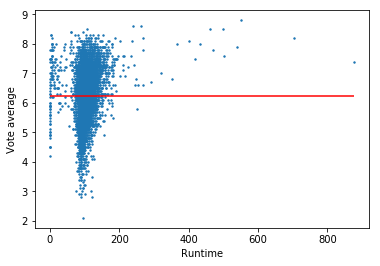

In [184]:
print('Correlation between runtime and vote is ' + str(np.corrcoef([float(i) for i in movies_metadata['runtime'].values], 
            [float(i) for i in movies_metadata['vote_average'].values])[0,1]))

plt.figure()
plt.scatter(x = [float(i) for i in movies_metadata['runtime'].values], 
            y = [float(i) for i in movies_metadata['vote_average'].values],
           s = 2)
plt.hlines(y = movies_metadata['vote_average'].mean(),
          xmin = min([float(i) for i in movies_metadata['runtime'].values]),
          xmax = max([float(i) for i in movies_metadata['runtime'].values]),
          colors = 'red')
plt.xlabel('Runtime')
plt.ylabel('Vote average')

If we split runtime in groups, we can see higher evaluation for short movies (less than hour), and after that longer movies get higher evaluations: 

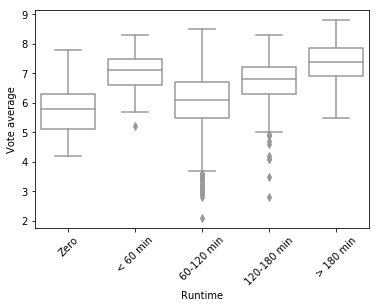

In [185]:
movies_metadata['runtime_group'] = ''
movies_metadata.loc[movies_metadata['runtime'] == 0, 'runtime_group'] = 'Zero'
movies_metadata.loc[(movies_metadata['runtime'] > 0) & (movies_metadata['runtime'] < 60), 'runtime_group'] = '< 60 min'
movies_metadata.loc[(movies_metadata['runtime'] >= 60) & (movies_metadata['runtime'] < 120), 'runtime_group'] = '60-120 min'
movies_metadata.loc[(movies_metadata['runtime'] >= 120) & (movies_metadata['runtime'] < 180), 'runtime_group'] = '120-180 min'
movies_metadata.loc[(movies_metadata['runtime'] >= 180), 'runtime_group'] = '> 180 min'


p = sns.boxplot(x = "runtime_group", y = "vote_average", data = movies_metadata,
                 order = ['Zero', '< 60 min', '60-120 min', '120-180 min', '> 180 min'],
                 color = 'white')
p.set(xlabel='Runtime', ylabel='Vote average')
plt.xticks(rotation=45)
plt.show()

del p

Some statistics based on the final dataset:

In [188]:
for genre in [c for c in movies_metadata.columns if "genre_" in c]:
    if genre != 'genre_id':
        print(movies_metadata.groupby(genre)['vote_average'].mean())

genre_Action
0.0    6.215090
1.0    6.842857
Name: vote_average, dtype: float64
genre_Adventure
0.0    6.215794
1.0    6.901739
Name: vote_average, dtype: float64
genre_Animation
0.0    6.224024
1.0    6.819048
Name: vote_average, dtype: float64
genre_Comedy
0.0    6.216242
1.0    6.882456
Name: vote_average, dtype: float64
genre_Crime
0.0    6.221333
1.0    6.876923
Name: vote_average, dtype: float64
genre_Documentary
0.0    6.226953
1.0    7.057143
Name: vote_average, dtype: float64
genre_Drama
0.0    6.214201
1.0    6.821769
Name: vote_average, dtype: float64
genre_Family
0.0    6.220398
1.0    6.947761
Name: vote_average, dtype: float64
genre_Fantasy
0.0    6.219301
1.0    6.901220
Name: vote_average, dtype: float64
genre_History
0.0    6.226299
1.0    6.665217
Name: vote_average, dtype: float64
genre_Horror
0.0    6.222533
1.0    6.903922
Name: vote_average, dtype: float64
genre_Music
0.0    6.225862
1.0    6.842857
Name: vote_average, dtype: float64
genre_Mystery
0.0    6.221994


In [194]:
print(vote_avg_by_release_month)
print(movies_metadata['vote_average'].mean())

release_month
1     6.060913
2     6.133198
3     6.205788
4     6.103838
5     6.314959
6     6.210042
7     6.236439
8     6.109752
9     6.337179
10    6.241090
11    6.279075
12    6.420000
Name: vote_average, dtype: float64
6.227840562003661


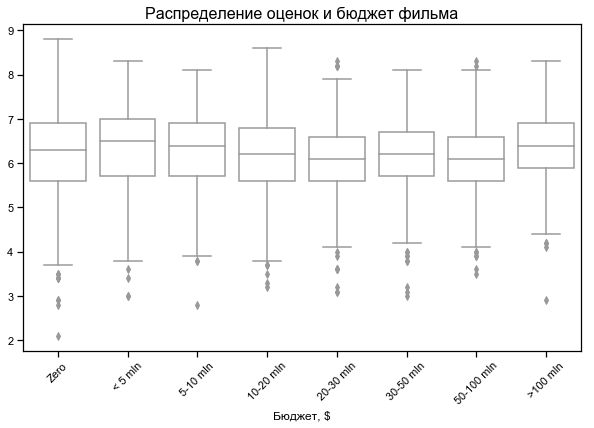

In [225]:
plt.figure(figsize=(10, 6))
sns.set_style({'font.sans-serif': 'Arial'})
sns.set_context("notebook")
p = sns.boxplot(x = "budget_float_group", y = "vote_average", data = movies_metadata,
                 order = ['Zero', '< 5 mln', '5-10 mln', '10-20 mln', '20-30 mln','30-50 mln', '50-100 mln', '>100 mln'],
                 color = 'white')
p.axes.set_title("Распределение оценок и бюджет фильма",fontsize=16)
p.set_xlabel("Бюджет, $")
p.set_ylabel("")
plt.xticks(rotation=45)
plt.show()

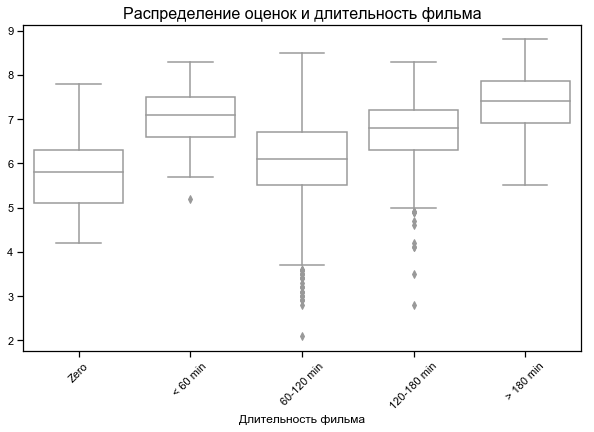

In [226]:
plt.figure(figsize=(10, 6))
sns.set_style({'font.sans-serif': 'Arial'})
sns.set_context("notebook")
p = sns.boxplot(x = "runtime_group", y = "vote_average", data = movies_metadata,
                 order = ['Zero', '< 60 min', '60-120 min', '120-180 min', '> 180 min'],
                 color = 'white')
p.axes.set_title("Распределение оценок и длительность фильма",fontsize=16)
p.set_xlabel("Длительность фильма")
p.set_ylabel("")
plt.xticks(rotation=45)
plt.show()

## 1.3. Keywords

These are movie plot keywords, each movie can have several

In [228]:
# Read data, remove movies which are not in the final list

keywords = pd.read_csv("keywords.csv", low_memory=False)

keywords = keywords[keywords['id'].isin(list(movies_metadata.index))]
keywords = keywords.drop_duplicates()

keywords.set_index('id', inplace = True)

keywords.head()

,keywords
id,
17182,"[{'id': 570, 'name': 'rape'}, {'id': 1419, 'na..."
10607,"[{'id': 248, 'name': 'date'}, {'id': 398, 'nam..."
9536,"[{'id': 4166, 'name': 'biotope'}, {'id': 4459,..."
755,"[{'id': 246, 'name': 'dancing'}, {'id': 380, '..."
9623,"[{'id': 1417, 'name': 'jurors'}, {'id': 1936, ..."


In [230]:
keywords.loc[12,].values # Nemo

array(["[{'id': 494, 'name': 'father son relationship'}, {'id': 10026, 'name': 'harbor'}, {'id': 14785, 'name': 'underwater'}, {'id': 33759, 'name': 'fish tank'}, {'id': 33760, 'name': 'great barrier reef'}, {'id': 156948, 'name': 'missing child'}, {'id': 179430, 'name': 'aftercreditsstinger'}, {'id': 179431, 'name': 'duringcreditsstinger'}, {'id': 180557, 'name': 'short term memory loss'}, {'id': 180568, 'name': 'clownfish'}, {'id': 180574, 'name': 'father son reunion'}, {'id': 181068, 'name': 'protective father'}]"],
      dtype=object)

As for other multidimensial variables we analyzed before, for keywords we will create a "wide" dataframe, where each column is a separate keywords

In [231]:
# Create 'long' dataframe with (movie id, keyword) pairs

keywords_dict = {}

i = 0

for movie_id in keywords.index:
    for keyword_id in eval(keywords.loc[movie_id][0]):
        keywords_dict[i] = {'movie_id': movie_id,
                           'keyword': keyword_id['name']}
        i = i + 1

del i

keywords_df = pd.DataFrame.from_dict(keywords_dict, orient = "index")

In [232]:
# Remove keywords which appear less than 10 times

keywords_df_count = keywords_df.groupby(['keyword']).count()

keywords_df_count_more_than_once = keywords_df_count[keywords_df_count['movie_id'] >= 10]

keywords_df_more_than_once = keywords_df[keywords_df['keyword'].isin(list(keywords_df_count_more_than_once.index))]

del keywords_df_count, keywords_df_count_more_than_once, keywords_dict

In [233]:
# Create 'wide' table with keywords (first remove apostrophes and replace spaces with underscore)

keywords_df_more_than_once.loc[:, 'keyword_clean'] = [s.replace(" ", "_").replace("\'", "") for s in keywords_df_more_than_once['keyword']]

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [234]:
keywords_df_more_than_once.loc[:,'value'] = 1

In [235]:
keywords_df_more_than_once_wide = keywords_df_more_than_once.pivot(index = 'movie_id', columns = "keyword_clean", values = "value")
keywords_df_more_than_once_wide = pd.DataFrame(keywords_df_more_than_once_wide.to_records())

keywords_df_more_than_once_wide = keywords_df_more_than_once_wide.set_index(['movie_id'])

del keywords_df_more_than_once

keywords_df_more_than_once_wide_columns = keywords_df_more_than_once_wide.columns

There are similar keywords, and we will unite them in groups, because some words appear very rarely
We will use Jaccard similarity for this

In [236]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

jaccard_sim_df = pd.DataFrame({'s1': [], 's2': [], 'sim_value': []})

i = 0

for col1 in keywords_df_more_than_once_wide_columns:
    for col2 in keywords_df_more_than_once_wide_columns:
        if (col1 != col2):
            s1 = col1.replace("_", " ")
            s2 = col2.replace("_", " ")
            
            if (get_jaccard_sim(s1, s2) > 0):
                jaccard_sim_df.loc[i] = [s1, s2, get_jaccard_sim(s1, s2)]
                i = i + 1

del i, s1, s2, col1, col2

jaccard_sim_df.head(5)

,s1,s2,sim_value
0,accident,car accident,0.500000
1,addiction,drug addiction,0.500000
2,adult animation,animation,0.500000
3,adult animation,based on young adult novel,0.166667
4,adult animation,becoming an adult,0.250000


We will leave only unique pairs:

In [237]:
jaccard_sim_df['s1_s2'] = jaccard_sim_df['s1'] + '_' + jaccard_sim_df['s2']
jaccard_sim_df['s2_s1'] = jaccard_sim_df['s2'] + '_' + jaccard_sim_df['s1']

jaccard_sim_df['ind'] = jaccard_sim_df.index

jaccard_sim_df_merged = jaccard_sim_df.merge(jaccard_sim_df.reindex(), left_on = 's1_s2', right_on = 's2_s1', how = 'outer')

jaccard_sim_df_merged = jaccard_sim_df_merged[jaccard_sim_df_merged['ind_x'] < jaccard_sim_df_merged['ind_y']]

jaccard_sim_df = jaccard_sim_df_merged[['s1_x', 's2_x', 'sim_value_x']]
jaccard_sim_df = jaccard_sim_df.rename(columns = {'s1_x': 's1', 's2_x': 's2', 'sim_value_x': 'sim_value'})

Now we will create clusters of similar keywrods, using only pairs with > 0.34 similarity

In [238]:
# Create list of lists with similar keywords

def create_list_of_lists_from_jaccard_sim_df(jaccard_sim_df_input):

    dict_of_lists = {}

    for tup in jaccard_sim_df_input.itertuples():

        add_bool = 0

        if (len(dict_of_lists) == 0):
            dict_of_lists[len(dict_of_lists)] = [tup[1], tup[2]]
            add_bool = 1


        for k, v in dict_of_lists.items():

            if ((tup[1] in v) & (tup[2] not in v)):
                dict_of_lists[k] = dict_of_lists[k] + [tup[2]]
                add_bool = 1

            if ((tup[1] not in v) & (tup[2] in v)):
                dict_of_lists[k] = dict_of_lists[k] + [tup[1]]
                add_bool = 1

        if (add_bool == 0):

            dict_of_lists[len(dict_of_lists)] = [tup[1], tup[2]]

    return list(dict_of_lists.values())

jaccard_sim_clusters = create_list_of_lists_from_jaccard_sim_df(jaccard_sim_df[jaccard_sim_df['sim_value'] > 0.34])

keywords_df_more_than_once_wide = keywords_df_more_than_once_wide.fillna(0)

Add columns for each cluster of keywords:

In [239]:
# Create columns from groups of keywords

i = 0

for cluster_i in jaccard_sim_clusters:
    cluster_i_columns = [str(col).replace(" ", "_") for col in cluster_i]
    cluster_i_col_sum = keywords_df_more_than_once_wide.loc[:, cluster_i_columns].sum(axis = 1)
    cluster_i_col_sum[cluster_i_col_sum > 0] = 1
    cluster_i_col_sum = pd.DataFrame(cluster_i_col_sum)
    cluster_i_col_sum.columns = ['keyword_cluster_' + str(i)]
    keywords_df_more_than_once_wide = keywords_df_more_than_once_wide.merge(cluster_i_col_sum, 
                                                                            left_index = True,
                                                                           right_index = True)
    i = i + 1

del i, cluster_i_columns, cluster_i

Keep only keywords (and groups) which appear > 100 times

In [240]:
keywords_df_more_than_once_wide_count = pd.DataFrame(keywords_df_more_than_once_wide.sum())
keywords_df_more_than_once_wide_count.columns = ['cnt']
keywords_to_include_in_model = keywords_df_more_than_once_wide_count[keywords_df_more_than_once_wide_count['cnt'] > 100].index
keywords_df_to_include_in_model = keywords_df_more_than_once_wide.loc[:,list(keywords_to_include_in_model)]

In [241]:
# Add to full data

movies_metadata = movies_metadata.merge(keywords_df_more_than_once_wide, 
                                        left_index = True, right_index = True, how = "left")

In [243]:
movies_metadata.describe()

,revenue,runtime,vote_average,vote_count,release_date_dateid,budget_float,belongs_to_collection_tf,genre_id,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_ScienceFiction,genre_TVMovie,genre_Thriller,genre_War,genre_Western,prod_comp_id,prod_comp_2,prod_comp_4,prod_comp_5,prod_comp_12,prod_comp_14,prod_comp_27,prod_comp_33,prod_comp_43,prod_comp_79,prod_comp_288,prod_comp_306,prod_comp_441,prod_comp_444,prod_comp_491,prod_comp_508,prod_comp_694,prod_comp_856,prod_comp_1632,prod_comp_3823,prod_comp_5358,prod_comp_6194,prod_comp_7295,prod_comp_7405,prod_comp_8411,prod_comp_9195,prod_comp_9349,prod_comp_10163,prod_country_id,prod_country_Belgium,prod_country_Canada,prod_country_France,prod_country_Germany,prod_country_Italy,prod_country_Spain,prod_country_UnitedKingdom,prod_country_UnitedStatesofAmerica,spoken_lang_id,spoken_lang_de,spoken_lang_en,spoken_lang_es,spoken_lang_fr,spoken_lang_it,spoken_lang_ru,release_year,release_month,release_month_is_dec,release_month_is_may_sep_dec,1940s,1950s,1960s,1970s,1980s,19th_century,3d,accident,actress,addiction,adolescence,adoption,adult_animation,adultery,adventure,afghanistan,africa,african_american,aftercreditsstinger,afterlife,age_difference,agent,aids,airplane,airport,alaska,alcohol,alcoholic,alcoholism,alien,alien_invasion,alien_life-form,ambition,american,american_abroad,american_football,american_football_player,amnesia,ancient_world,android,angel,animal,animal_attack,animal_horror,animation,anime,anthropomorphism,anti_hero,apartment,apocalypse,archaeologist,architect,army,arrest,art,artificial_intelligence,artist,assassin,assassination,astronaut,asylum,attack,australia,author,autism,baby,babysitter,ballet,bank,bank_robber,bank_robbery,bar,barbie,baseball,based_on_childrens_book,based_on_comic,based_on_graphic_novel,based_on_manga,based_on_novel,based_on_play_or_musical,based_on_true_events,based_on_true_story,based_on_tv_series,based_on_video_game,based_on_young_adult_novel,basketball,battle,beach,bear,beating,beauty,becoming_an_adult,beer,berlin,best_friend,betrayal,bible,biography,birthday,bite,black_and_white,black_magic,black_people,blackmail,blindness_and_impaired_vision,blood,blood_splatter,boarding_school,boat,bodyguard,bollywood,bomb,book,boston,boxer,boy,boyfriend,bravery,brazilian,break-up,bride,bridge,british,brother,brother_brother_relationship,brother_sister_relationship,brutality,bully,bullying,business_man,cabin,california,camping,canada,cancer,cannibal,cannibalism,capitalism,captive,car,car_accident,car_chase,car_crash,car_race,career,casino,castle,cat,catholicism,cave,celebration,celebrity,cell_phone,cgi,chainsaw,chaos,chase,cheating,cheerleader,chicago,child,child_abuse,child_hero,child_prodigy,childhood_friends,children,china,christian,christianity,christmas,christmas_eve,christmas_party,church,cia,civil_war,...,stalking,star,step_father,stop_motion,storm,stranded,stranger,street_gang,strip_club,stripper,strong_woman,student,submarine,subway,success,suffering,suicide,suicide_attempt,summer,super_powers,superhero,superhero_team,superhuman,superhuman_strength,supernatural,supernatural_powers,surrealism,surveillance,survival,survivor,suspense,swimming_pool,sword,sword_and_sorcery,sword_fight,talking_animal,tattoo,taxi,taxi_driver,teacher,technology,teen_comedy,teen_movie,teenage_boy,teenage_crush,teenage_girl,teenage_romance,teenage_sexuality,teenager,television,terminal_illness,terror,terrorism,terrorist,texas,thailand,thanksgiving,theft,therapist,thief,thriller,tiger,time,time_travel,torture,toy,toy_comes_to_life,tragedy,train,training,traitor,transformation,trapped,trauma,travel,treasure,treasure_hunt,tree,trial,tv_movie,tv_show,twin_brother,twins,u.s._army,uncle,undercover,undercover_agent,undercover_cop,underdog,underground,underwater,underwear,underworld,unemployment,university,unlikely_friendship,unsimulate

In [262]:
movies_metadata.iloc[:,range(np.where(movies_metadata.columns == 'release_month_is_may_sep_dec')[0][0] + 2, len(movies_metadata.columns))] = movies_metadata.iloc[:,range(np.where(movies_metadata.columns == 'release_month_is_may_sep_dec')[0][0] + 2, len(movies_metadata.columns))].fillna(0)

In [263]:
movies_metadata.describe()

,revenue,runtime,vote_average,vote_count,release_date_dateid,budget_float,belongs_to_collection_tf,genre_id,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_ScienceFiction,genre_TVMovie,genre_Thriller,genre_War,genre_Western,prod_comp_id,prod_comp_2,prod_comp_4,prod_comp_5,prod_comp_12,prod_comp_14,prod_comp_27,prod_comp_33,prod_comp_43,prod_comp_79,prod_comp_288,prod_comp_306,prod_comp_441,prod_comp_444,prod_comp_491,prod_comp_508,prod_comp_694,prod_comp_856,prod_comp_1632,prod_comp_3823,prod_comp_5358,prod_comp_6194,prod_comp_7295,prod_comp_7405,prod_comp_8411,prod_comp_9195,prod_comp_9349,prod_comp_10163,prod_country_id,prod_country_Belgium,prod_country_Canada,prod_country_France,prod_country_Germany,prod_country_Italy,prod_country_Spain,prod_country_UnitedKingdom,prod_country_UnitedStatesofAmerica,spoken_lang_id,spoken_lang_de,spoken_lang_en,spoken_lang_es,spoken_lang_fr,spoken_lang_it,spoken_lang_ru,release_year,release_month,release_month_is_dec,release_month_is_may_sep_dec,1940s,1950s,1960s,1970s,1980s,19th_century,3d,accident,actress,addiction,adolescence,adoption,adult_animation,adultery,adventure,afghanistan,africa,african_american,aftercreditsstinger,afterlife,age_difference,agent,aids,airplane,airport,alaska,alcohol,alcoholic,alcoholism,alien,alien_invasion,alien_life-form,ambition,american,american_abroad,american_football,american_football_player,amnesia,ancient_world,android,angel,animal,animal_attack,animal_horror,animation,anime,anthropomorphism,anti_hero,apartment,apocalypse,archaeologist,architect,army,arrest,art,artificial_intelligence,artist,assassin,assassination,astronaut,asylum,attack,australia,author,autism,baby,babysitter,ballet,bank,bank_robber,bank_robbery,bar,barbie,baseball,based_on_childrens_book,based_on_comic,based_on_graphic_novel,based_on_manga,based_on_novel,based_on_play_or_musical,based_on_true_events,based_on_true_story,based_on_tv_series,based_on_video_game,based_on_young_adult_novel,basketball,battle,beach,bear,beating,beauty,becoming_an_adult,beer,berlin,best_friend,betrayal,bible,biography,birthday,bite,black_and_white,black_magic,black_people,blackmail,blindness_and_impaired_vision,blood,blood_splatter,boarding_school,boat,bodyguard,bollywood,bomb,book,boston,boxer,boy,boyfriend,bravery,brazilian,break-up,bride,bridge,british,brother,brother_brother_relationship,brother_sister_relationship,brutality,bully,bullying,business_man,cabin,california,camping,canada,cancer,cannibal,cannibalism,capitalism,captive,car,car_accident,car_chase,car_crash,car_race,career,casino,castle,cat,catholicism,cave,celebration,celebrity,cell_phone,cgi,chainsaw,chaos,chase,cheating,cheerleader,chicago,child,child_abuse,child_hero,child_prodigy,childhood_friends,children,china,christian,christianity,christmas,christmas_eve,christmas_party,church,cia,civil_war,...,stalking,star,step_father,stop_motion,storm,stranded,stranger,street_gang,strip_club,stripper,strong_woman,student,submarine,subway,success,suffering,suicide,suicide_attempt,summer,super_powers,superhero,superhero_team,superhuman,superhuman_strength,supernatural,supernatural_powers,surrealism,surveillance,survival,survivor,suspense,swimming_pool,sword,sword_and_sorcery,sword_fight,talking_animal,tattoo,taxi,taxi_driver,teacher,technology,teen_comedy,teen_movie,teenage_boy,teenage_crush,teenage_girl,teenage_romance,teenage_sexuality,teenager,television,terminal_illness,terror,terrorism,terrorist,texas,thailand,thanksgiving,theft,therapist,thief,thriller,tiger,time,time_travel,torture,toy,toy_comes_to_life,tragedy,train,training,traitor,transformation,trapped,trauma,travel,treasure,treasure_hunt,tree,trial,tv_movie,tv_show,twin_brother,twins,u.s._army,uncle,undercover,undercover_agent,undercover_cop,underdog,underground,underwater,underwear,underworld,unemployment,university,unlikely_friendship,unsimulate

To reduce number of columns we will apply PCA to keywords data
And finally add this data to full dataset

PCA should be applied to the same samples, which then will be used in training \ validation \ testing.
So now we will split the sample into 3 parts: 
- train (we will train PCA on it and will use it for training the model itself)
- validation (will compare PCA results and will tune parameters of the model afterwards)
- test (will use for final comparison)

In [264]:
full_sample_size = len(list(movies_metadata.index))
train_sample_size = int(math.modf(full_sample_size/2)[1])
validation_sample_size = int(math.modf((full_sample_size - train_sample_size)/2)[1])
test_sample_size = int(full_sample_size - train_sample_size - validation_sample_size)

print("Full sample size - " + str(full_sample_size) + ", train sample size - " + str(train_sample_size) + ", validation sample size - " + str(validation_sample_size) + ", test sample size - " + str(test_sample_size))

Full sample size - 6548, train sample size - 3274, validation sample size - 1637, test sample size - 1637


In [265]:
random.seed(100)

movies_metadata_index = list(movies_metadata.index)
random.shuffle(movies_metadata_index)

train_sample_movie_ids = movies_metadata_index[0:(train_sample_size)]

validation_sample_movie_ids = movies_metadata_index[train_sample_size:(train_sample_size + validation_sample_size)]

test_sample_movie_ids = movies_metadata_index[(train_sample_size + validation_sample_size):]

# Check
list(set(train_sample_movie_ids + validation_sample_movie_ids + test_sample_movie_ids)).sort() == list(movies_metadata.index).sort()

True

In [266]:
movies_metadata['sample'] = ''
movies_metadata.loc[train_sample_movie_ids,'sample'] = 'train'
movies_metadata.loc[validation_sample_movie_ids,'sample'] = 'validation'
movies_metadata.loc[test_sample_movie_ids,'sample'] = 'test'
movies_metadata['sample'].value_counts()

train         3270
test          1640
validation    1638
Name: sample, dtype: int64

In [267]:
keywords_X_train = movies_metadata.loc[train_sample_movie_ids, keywords_to_include_in_model]
keywords_X_validation = movies_metadata.loc[validation_sample_movie_ids, keywords_to_include_in_model]
keywords_X_test = movies_metadata.loc[test_sample_movie_ids, keywords_to_include_in_model]

In [268]:
# Applying PCA to train set

from sklearn.decomposition import PCA

keyword_pca = PCA() 
keyword_pca.fit(keywords_X_train) 
keywords_X_train_pca = keyword_pca.transform(keywords_X_train) 

ex_variance = np.var(keywords_X_train_pca, axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)

In [269]:
# Check number of componentes which explain at lest 1% of variance

pca_n_components = len([i for i in list(ex_variance_ratio) if i > 0.01])
print(pca_n_components)

30


In [270]:
# Applying final number of PCA components and saving PCA components

keyword_pca = PCA(n_components = int(pca_n_components))
keyword_pca.fit(keywords_X_train) 

keywords_X_train_pca = keyword_pca.transform(keywords_X_train) 
keywords_X_validation_pca = keyword_pca.transform(keywords_X_validation) 
keywords_X_test_pca = keyword_pca.transform(keywords_X_test) 

keywords_X_train_pca_df = pd.DataFrame(keywords_X_train_pca)
keywords_X_train_pca_df.columns = ["pca_" + str(i) for i in keywords_X_train_pca_df.columns]

keywords_X_validation_pca_df = pd.DataFrame(keywords_X_validation_pca)
keywords_X_validation_pca_df.columns = ["pca_" + str(i) for i in keywords_X_validation_pca_df.columns]

keywords_X_test_pca_df = pd.DataFrame(keywords_X_test_pca)
keywords_X_test_pca_df.columns = ["pca_" + str(i) for i in keywords_X_test_pca_df.columns]

keywords_X_train_pca_df['id'] = keywords_X_train.index
keywords_X_train_pca_df.set_index(['id'], inplace = True)

keywords_X_validation_pca_df['id'] = keywords_X_validation.index
keywords_X_validation_pca_df.set_index(['id'], inplace = True)

keywords_X_test_pca_df['id'] = keywords_X_test.index
keywords_X_test_pca_df.set_index(['id'], inplace = True)

keywords_pca_df = pd.concat([keywords_X_train_pca_df, keywords_X_validation_pca_df, keywords_X_test_pca_df])

keywords_pca_columns = keywords_pca_df.columns

In [271]:
# Saving PCA components to full dataset

movies_metadata = movies_metadata.merge(keywords_pca_df, left_index = True, right_index = True, how = "left")

ValueError: fill value must be in categories

In [274]:
movies_metadata.iloc[:,range(len(movies_metadata.columns) - 30, len(movies_metadata.columns))] = movies_metadata.iloc[:,range(len(movies_metadata.columns) - 30, len(movies_metadata.columns))].fillna(0)

In [275]:
movies_metadata.describe()

,revenue,runtime,vote_average,vote_count,release_date_dateid,budget_float,belongs_to_collection_tf,genre_id,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_ScienceFiction,genre_TVMovie,genre_Thriller,genre_War,genre_Western,prod_comp_id,prod_comp_2,prod_comp_4,prod_comp_5,prod_comp_12,prod_comp_14,prod_comp_27,prod_comp_33,prod_comp_43,prod_comp_79,prod_comp_288,prod_comp_306,prod_comp_441,prod_comp_444,prod_comp_491,prod_comp_508,prod_comp_694,prod_comp_856,prod_comp_1632,prod_comp_3823,prod_comp_5358,prod_comp_6194,prod_comp_7295,prod_comp_7405,prod_comp_8411,prod_comp_9195,prod_comp_9349,prod_comp_10163,prod_country_id,prod_country_Belgium,prod_country_Canada,prod_country_France,prod_country_Germany,prod_country_Italy,prod_country_Spain,prod_country_UnitedKingdom,prod_country_UnitedStatesofAmerica,spoken_lang_id,spoken_lang_de,spoken_lang_en,spoken_lang_es,spoken_lang_fr,spoken_lang_it,spoken_lang_ru,release_year,release_month,release_month_is_dec,release_month_is_may_sep_dec,1940s,1950s,1960s,1970s,1980s,19th_century,3d,accident,actress,addiction,adolescence,adoption,adult_animation,adultery,adventure,afghanistan,africa,african_american,aftercreditsstinger,afterlife,age_difference,agent,aids,airplane,airport,alaska,alcohol,alcoholic,alcoholism,alien,alien_invasion,alien_life-form,ambition,american,american_abroad,american_football,american_football_player,amnesia,ancient_world,android,angel,animal,animal_attack,animal_horror,animation,anime,anthropomorphism,anti_hero,apartment,apocalypse,archaeologist,architect,army,arrest,art,artificial_intelligence,artist,assassin,assassination,astronaut,asylum,attack,australia,author,autism,baby,babysitter,ballet,bank,bank_robber,bank_robbery,bar,barbie,baseball,based_on_childrens_book,based_on_comic,based_on_graphic_novel,based_on_manga,based_on_novel,based_on_play_or_musical,based_on_true_events,based_on_true_story,based_on_tv_series,based_on_video_game,based_on_young_adult_novel,basketball,battle,beach,bear,beating,beauty,becoming_an_adult,beer,berlin,best_friend,betrayal,bible,biography,birthday,bite,black_and_white,black_magic,black_people,blackmail,blindness_and_impaired_vision,blood,blood_splatter,boarding_school,boat,bodyguard,bollywood,bomb,book,boston,boxer,boy,boyfriend,bravery,brazilian,break-up,bride,bridge,british,brother,brother_brother_relationship,brother_sister_relationship,brutality,bully,bullying,business_man,cabin,california,camping,canada,cancer,cannibal,cannibalism,capitalism,captive,car,car_accident,car_chase,car_crash,car_race,career,casino,castle,cat,catholicism,cave,celebration,celebrity,cell_phone,cgi,chainsaw,chaos,chase,cheating,cheerleader,chicago,child,child_abuse,child_hero,child_prodigy,childhood_friends,children,china,christian,christianity,christmas,christmas_eve,christmas_party,church,cia,civil_war,...,suspense,swimming_pool,sword,sword_and_sorcery,sword_fight,talking_animal,tattoo,taxi,taxi_driver,teacher,technology,teen_comedy,teen_movie,teenage_boy,teenage_crush,teenage_girl,teenage_romance,teenage_sexuality,teenager,television,terminal_illness,terror,terrorism,terrorist,texas,thailand,thanksgiving,theft,therapist,thief,thriller,tiger,time,time_travel,torture,toy,toy_comes_to_life,tragedy,train,training,traitor,transformation,trapped,trauma,travel,treasure,treasure_hunt,tree,trial,tv_movie,tv_show,twin_brother,twins,u.s._army,uncle,undercover,undercover_agent,undercover_cop,underdog,underground,underwater,underwear,underworld,unemployment,university,unlikely_friendship,unsimulated_sex,unsociability,upper_class,usa,usa_president,vacation,vampire,van,vandalism,vatican,venice,very_little_dialogue,victim,video_game,vigilante,viking,village,villain,violence,virgin,virtual_reality,virus,vision,waitress,wall_street,war,war_crimes,washington_d.c.,water,wealth,weapon,wedding,werewolf,wheelchair,white_house,

## 1.4. Credits

Credits info is about people who took part in movie. Here we will use cast and crew (producer, directo, editor and screenplay), in the following way: for each person and each movie we will find all movies he was involved in before, and the rating of those movies as of month of release of the movie analyzed. We will aggregate all the ratings of all these movies. This should show how 'popular' were cast members and crew before the movie came out.

In [276]:
# Read data

credits = pd.read_csv("credits.csv")
credits_full = credits.copy()

In [277]:
# Keep only crew

crew = credits[['id', 'crew']].drop_duplicates()

crew = crew.sort_values('id',ascending = False).groupby('id').head(1)

crew.set_index('id', inplace = True)

crew.head()

,crew
id,
469172,"[{'credit_id': '5981feabc3a3680cfb016ff9', 'de..."
468707,"[{'credit_id': '597e22f69251415d7801c74a', 'de..."
468343,"[{'credit_id': '597ae87a925141364e00a73e', 'de..."
467731,"[{'credit_id': '5975903bc3a3680cb700867b', 'de..."
465044,"[{'credit_id': '595f97249251412251083338', 'de..."


In [278]:
# Create 'long' dataframe with (movie id, person job, person name) info

crew_dict = {}

i = 0

print("Number of movies to check = " + str(len(list(crew.index))))

movie_id_counter = 0 

movie_id_mem = 0

for movie_id in list(crew.index):
    movie_id_mem = movie_id
    if (movie_id_counter % 5000 == 0):
        print(str(movie_id_counter) + ': ' + str(datetime.now()))
    for crew_id in eval(crew.loc[movie_id][0]):
        crew_dict[i] = {'movie_id': movie_id,
                        'person_job': crew_id['job'],
                           'person_name': crew_id['name']}
        i = i + 1
    movie_id_counter = movie_id_counter + 1

del i

Number of movies to check = 45432
0: 2019-09-01 15:19:44.230893
5000: 2019-09-01 15:19:45.819691
10000: 2019-09-01 15:19:47.218167
15000: 2019-09-01 15:19:48.596525
20000: 2019-09-01 15:19:49.934900
25000: 2019-09-01 15:19:51.226447
30000: 2019-09-01 15:19:52.603764
35000: 2019-09-01 15:19:53.998036
40000: 2019-09-01 15:19:55.532931
45000: 2019-09-01 15:19:57.986371


In [279]:
crew_df = pd.DataFrame.from_dict(crew_dict, orient = "index")

crew_df.head(5)

,movie_id,person_job,person_name
0,469172,Producer,Paulo Branco
1,469172,Production Design,Zé Branco
2,469172,Costume Design,Zé Branco
3,469172,Sound Mixer,Jean-Claude Brisson
4,469172,Idea,João Botelho


In [280]:
# Specify crew we need

crew_df['crew_we_need'] = 0

crew_df.loc[crew_df['movie_id'].isin(list(movies_metadata.index)), 'crew_we_need'] = 1

crew_df.groupby('crew_we_need')['person_name'].count()

crew_we_need
0    287858
1    175978
Name: person_name, dtype: int64

In [281]:
movies_metadata_init['release_date_datetime'] = [datetime_or_19000101(s) for s in movies_metadata_init['release_date']]

In [282]:
crew_df = crew_df.merge(movies_metadata_init[['id', 'release_date_datetime']],                              
                                left_on = "movie_id",
                                right_on = "id",
                                how = "left")

crew_df = crew_df.drop(axis = 'columns', labels = ['id'])

In [283]:
crew_df = crew_df[~crew_df["release_date_datetime"].isna()]

crew_df["release_date_dateid"] = [ts.year*10000 + ts.month*100 + ts.day for ts in crew_df["release_date_datetime"]]

crew_df["release_date_month"] = [int(math.modf(d/100)[1]) for d in crew_df["release_date_dateid"]]

crew_df = crew_df.set_index(['movie_id', 'release_date_month', 'person_name']).sort_index()

crew_df.head()

person_job  \
movie_id release_date_month person_name                               
2        198810             Aki Kaurismäki               Screenplay   
                            Aki Kaurismäki                 Director   
                            Raija Talvio                     Editor   
                            Risto Karhula         Production Design   
                            Timo Salminen   Director of Photography   

                                            crew_we_need  \
movie_id release_date_month person_name                    
2        198810             Aki Kaurismäki             0   
                            Aki Kaurismäki             0   
                            Raija Talvio               0   
                            Risto Karhula              0   
                            Timo Salminen              0   

                                           release_date_datetime  \
movie_id release_date_month person_name                            
2        198810             Aki Kaurismäki            1988-10-21   
                            Aki Kaurismäki            1988-10-21   
                            Raija Talvio              1988-10-21   
                            Risto Karhula             1988-10-21   
                            Timo Salminen             1988-10-21   

                                            release_date_dateid  
movie_id release_date_month person_name                          
2        198810             Aki Kaurismäki             19881021  
                            Aki Kaurismäki             19881021  
                            Raija Talvio               19881021  
                            Risto Karhula              19881021  
                            Timo Salminen              19881021

In [284]:
# Keep only cast

credits = credits[['id', 'cast']].drop_duplicates()
credits.set_index('id', inplace = True)

credits.head()

,cast
id,
862,"[{'cast_id': 14, 'character': 'Woody (voice)',..."
8844,"[{'cast_id': 1, 'character': 'Alan Parrish', '..."
15602,"[{'cast_id': 2, 'character': 'Max Goldman', 'c..."
31357,"[{'cast_id': 1, 'character': ""Savannah 'Vannah..."
11862,"[{'cast_id': 1, 'character': 'George Banks', '..."


In [285]:
# Create 'long' dataframe with (movie id, person id, person name) info

credits_dict = {}

i = 0

for movie_id in list(credits.index):
    #print(credits.loc[movie_id])
    for credits_id in eval(credits.loc[movie_id]['cast']):
        #print(credits_id)
        credits_dict[i] = {'movie_id': movie_id,
                           'person_name': credits_id['name']}
        i = i + 1

del i

credits_df = pd.DataFrame.from_dict(credits_dict, orient = "index")

credits_df.head(5)

,movie_id,person_name
0,862,Tom Hanks
1,862,Tim Allen
2,862,Don Rickles
3,862,Jim Varney
4,862,Wallace Shawn


In [286]:
# Specify cast we need

credits_df['cast_we_need'] = 0

credits_df.loc[credits_df['movie_id'].isin(list(movies_metadata.index)), 'cast_we_need'] = 1

credits_df.groupby('cast_we_need')['person_name'].count()

cast_we_need
0    421887
1    140157
Name: person_name, dtype: int64

In [287]:
credits_df = credits_df.merge(movies_metadata_init[['id', 'release_date_datetime']],                              
                                left_on = "movie_id",
                                right_on = "id",
                                how = "left")

credits_df = credits_df.drop(axis = 'columns', labels = ['id'])

In [288]:
credits_df = credits_df[~credits_df["release_date_datetime"].isna()]

credits_df["release_date_dateid"] = [ts.year*10000 + ts.month*100 + ts.day for ts in credits_df["release_date_datetime"]]

credits_df["release_date_month"] = [int(math.modf(d/100)[1]) for d in credits_df["release_date_dateid"]]

credits_df = credits_df.set_index(['movie_id', 'release_date_month', 'person_name']).sort_index()

credits_df.head()

cast_we_need  \
movie_id release_date_month person_name                      
2        198810             Eetu Hilkamo                 0   
                            Matti Pellonpää              0   
                            Susanna Haavisto             0   
                            Turo Pajala                  0   
3        198610             Esko Nikkari                 0   

                                             release_date_datetime  \
movie_id release_date_month person_name                              
2        198810             Eetu Hilkamo                1988-10-21   
                            Matti Pellonpää             1988-10-21   
                            Susanna Haavisto            1988-10-21   
                            Turo Pajala                 1988-10-21   
3        198610             Esko Nikkari                1986-10-16   

                                              release_date_dateid  
movie_id release_date_month person_name                            
2        198810             Eetu Hilkamo                 19881021  
                            Matti Pellonpää              19881021  
                            Susanna Haavisto             19881021  
                            Turo Pajala                  19881021  
3        198610             Esko Nikkari                 19861016

In [289]:
movie_release_date = credits_df.loc[credits_df['cast_we_need'] == 1,].reset_index()[['movie_id', 'release_date_month']].drop_duplicates().set_index(['movie_id'])
#credits_df.loc[credits_df['movie_id'] == 19457,]
print(movie_release_date.head())
print(movie_release_date.shape)

          release_date_month
movie_id                    
12                    200305
14                    199909
16                    200005
17                    200601
18                    199705
(6523, 1)


In [290]:
# for each movie in movie_release_date:
#     for each person in this movie:
#         find all movies where this person was in and which were released before:
#             sum ratings of these movies made before the initial movie
#             save this as movie, actor, sum of ratings, number of votes

movie_cast_previous_movies_ratings = {}

print(datetime.now())

counter = 1

for i,r in movie_release_date.iterrows(): 
    if (counter % 100 == 0):
        print(str(counter) + ': ' + str(datetime.now()))
    movie_i = i
    #print(str(movie_i) + ": " + str(datetime.now()))
    movie_i_release_date_month = r[0]
    #print(str(movie_i_release_date_month) + ": " + str(datetime.now()))
    movie_i_cast = list(credits_df.loc[movie_i, ].index.get_level_values('person_name'))
    #print(str(movie_i_cast) + ": " + str(datetime.now()))
    movie_i_cast_previous_movies = []
    
    movie_i_cast_previous_movies = list(credits_df.loc[(credits_df.index.get_level_values('person_name').isin(movie_i_cast)) & (credits_df.index.get_level_values('release_date_month') < movie_i_release_date_month), ].index.get_level_values('movie_id'))

    #print(str(datetime.now()))
    movie_i_cast_previous_movies = list(set(movie_i_cast_previous_movies))
    #print(str(movie_i_cast_previous_movies) + ": " + str(datetime.now()))
    
    if (len(movie_i_cast_previous_movies) > 0):
        movie_i_previous_movies_i_rating = ratings_agr_by_movie_and_month.loc[(ratings_agr_by_movie_and_month.index.get_level_values('movieId').isin(movie_i_cast_previous_movies)) & (ratings_agr_by_movie_and_month.index.get_level_values('timestamp_month') < movie_i_release_date_month),]
     #   print(str(movie_i_previous_movies_i_rating) + ": " + str(datetime.now()))
        if (movie_i_previous_movies_i_rating.shape[0]) > 0:
            movie_cast_previous_movies_ratings[movie_i] = {'rating_count': movie_i_previous_movies_i_rating['rating']['count'].sum(),
                                                          'rating_sum': movie_i_previous_movies_i_rating['rating']['sum'].sum()}
      #  print(str(movie_cast_previous_movies_ratings) + ": " + str(datetime.now()))
            
    counter = counter + 1

print(datetime.now())
            
movie_cast_previous_movies_ratings_df = pd.DataFrame.from_dict(movie_cast_previous_movies_ratings, orient = "index")

print(movie_cast_previous_movies_ratings_df.head(3))

movie_cast_previous_movies_ratings_df.to_csv("movie_cast_previous_movies_ratings_df.csv")

2019-09-01 15:22:18.356183
100: 2019-09-01 15:22:37.104011
200: 2019-09-01 15:22:54.926295
300: 2019-09-01 15:23:12.294507
400: 2019-09-01 15:23:29.408490
500: 2019-09-01 15:23:48.711555
600: 2019-09-01 15:24:08.098632
700: 2019-09-01 15:24:27.496403
800: 2019-09-01 15:24:45.936753
900: 2019-09-01 15:25:03.732577
1000: 2019-09-01 15:25:21.934675
1100: 2019-09-01 15:25:40.125921
1200: 2019-09-01 15:25:59.975698
1300: 2019-09-01 15:26:19.085376
1400: 2019-09-01 15:26:39.771128
1500: 2019-09-01 15:26:57.912595
1600: 2019-09-01 15:27:17.155937
1700: 2019-09-01 15:27:34.998396
1800: 2019-09-01 15:27:56.091179
1900: 2019-09-01 15:28:15.518726
2000: 2019-09-01 15:28:34.570005
2100: 2019-09-01 15:28:52.876115
2200: 2019-09-01 15:29:10.473367
2300: 2019-09-01 15:29:28.460890
2400: 2019-09-01 15:29:47.794057
2500: 2019-09-01 15:30:07.028243
2600: 2019-09-01 15:30:25.243463
2700: 2019-09-01 15:30:42.530170
2800: 2019-09-01 15:31:00.879147
2900: 2019-09-01 15:31:20.096470
3000: 2019-09-01 15:31:40

In [291]:
movie_cast_previous_movies_ratings_df = pd.read_csv("movie_cast_previous_movies_ratings_df.csv")
movie_cast_previous_movies_ratings_df.columns = ['movie_id', 'rating_count', 'rating_sum']
movie_cast_previous_movies_ratings_df.set_index(['movie_id'], inplace = True)

In [292]:
print(movie_cast_previous_movies_ratings_df.shape)

(6193, 2)


In [293]:
print(movie_cast_previous_movies_ratings_df.head(3))

          rating_count  rating_sum
movie_id                          
12              102426    360662.0
14                3475     11491.0
16               86926    328640.0


In [294]:
movie_cast_previous_movies_ratings_df.describe()

,rating_count,rating_sum
count,6193.000000,6.193000e+03
mean,84135.906023,2.965446e+05
std,90504.350124,3.207921e+05
min,1.000000,2.000000e+00
25%,16002.000000,5.428150e+04
50%,55474.000000,1.940280e+05
75%,123605.000000,4.352895e+05
max,677891.000000,2.345882e+06


In [295]:
movies_metadata = movies_metadata.merge(movie_cast_previous_movies_ratings_df,
                                       left_index = True, right_index = True, how = 'left')

In [296]:
movies_metadata_saved_copy = movies_metadata.copy()
movies_metadata = movies_metadata[~movies_metadata['rating_count'].isna()]

movies_metadata.describe()

,revenue,runtime,vote_average,vote_count,release_date_dateid,budget_float,belongs_to_collection_tf,genre_id,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_ScienceFiction,genre_TVMovie,genre_Thriller,genre_War,genre_Western,prod_comp_id,prod_comp_2,prod_comp_4,prod_comp_5,prod_comp_12,prod_comp_14,prod_comp_27,prod_comp_33,prod_comp_43,prod_comp_79,prod_comp_288,prod_comp_306,prod_comp_441,prod_comp_444,prod_comp_491,prod_comp_508,prod_comp_694,prod_comp_856,prod_comp_1632,prod_comp_3823,prod_comp_5358,prod_comp_6194,prod_comp_7295,prod_comp_7405,prod_comp_8411,prod_comp_9195,prod_comp_9349,prod_comp_10163,prod_country_id,prod_country_Belgium,prod_country_Canada,prod_country_France,prod_country_Germany,prod_country_Italy,prod_country_Spain,prod_country_UnitedKingdom,prod_country_UnitedStatesofAmerica,spoken_lang_id,spoken_lang_de,spoken_lang_en,spoken_lang_es,spoken_lang_fr,spoken_lang_it,spoken_lang_ru,release_year,release_month,release_month_is_dec,release_month_is_may_sep_dec,1940s,1950s,1960s,1970s,1980s,19th_century,3d,accident,actress,addiction,adolescence,adoption,adult_animation,adultery,adventure,afghanistan,africa,african_american,aftercreditsstinger,afterlife,age_difference,agent,aids,airplane,airport,alaska,alcohol,alcoholic,alcoholism,alien,alien_invasion,alien_life-form,ambition,american,american_abroad,american_football,american_football_player,amnesia,ancient_world,android,angel,animal,animal_attack,animal_horror,animation,anime,anthropomorphism,anti_hero,apartment,apocalypse,archaeologist,architect,army,arrest,art,artificial_intelligence,artist,assassin,assassination,astronaut,asylum,attack,australia,author,autism,baby,babysitter,ballet,bank,bank_robber,bank_robbery,bar,barbie,baseball,based_on_childrens_book,based_on_comic,based_on_graphic_novel,based_on_manga,based_on_novel,based_on_play_or_musical,based_on_true_events,based_on_true_story,based_on_tv_series,based_on_video_game,based_on_young_adult_novel,basketball,battle,beach,bear,beating,beauty,becoming_an_adult,beer,berlin,best_friend,betrayal,bible,biography,birthday,bite,black_and_white,black_magic,black_people,blackmail,blindness_and_impaired_vision,blood,blood_splatter,boarding_school,boat,bodyguard,bollywood,bomb,book,boston,boxer,boy,boyfriend,bravery,brazilian,break-up,bride,bridge,british,brother,brother_brother_relationship,brother_sister_relationship,brutality,bully,bullying,business_man,cabin,california,camping,canada,cancer,cannibal,cannibalism,capitalism,captive,car,car_accident,car_chase,car_crash,car_race,career,casino,castle,cat,catholicism,cave,celebration,celebrity,cell_phone,cgi,chainsaw,chaos,chase,cheating,cheerleader,chicago,child,child_abuse,child_hero,child_prodigy,childhood_friends,children,china,christian,christianity,christmas,christmas_eve,christmas_party,church,cia,civil_war,...,sword,sword_and_sorcery,sword_fight,talking_animal,tattoo,taxi,taxi_driver,teacher,technology,teen_comedy,teen_movie,teenage_boy,teenage_crush,teenage_girl,teenage_romance,teenage_sexuality,teenager,television,terminal_illness,terror,terrorism,terrorist,texas,thailand,thanksgiving,theft,therapist,thief,thriller,tiger,time,time_travel,torture,toy,toy_comes_to_life,tragedy,train,training,traitor,transformation,trapped,trauma,travel,treasure,treasure_hunt,tree,trial,tv_movie,tv_show,twin_brother,twins,u.s._army,uncle,undercover,undercover_agent,undercover_cop,underdog,underground,underwater,underwear,underworld,unemployment,university,unlikely_friendship,unsimulated_sex,unsociability,upper_class,usa,usa_president,vacation,vampire,van,vandalism,vatican,venice,very_little_dialogue,victim,video_game,vigilante,viking,village,villain,violence,virgin,virtual_reality,virus,vision,waitress,wall_street,war,war_crimes,washington_d.c.,water,wealth,weapon,wedding,werewolf,wheelchair,white_house,widow,widower,wife,wife

In [297]:
movies_metadata.shape

(6228, 1144)

In [298]:
movies_metadata['previous_movies_rating'] = movies_metadata['rating_sum']/movies_metadata['rating_count']
#movies_metadata['previous_movies_rating'].filna(0)
movies_metadata['previous_movies_rating'].describe()

count    6228.000000
mean        3.471208
std         0.266348
min         1.761905
25%         3.357358
50%         3.492028
75%         3.616823
max         4.500000
Name: previous_movies_rating, dtype: float64

## 1.5. Oscars

Being an Oscar nominee or winner can also be used as a predictor: it is more probable that Oscar nominees/ winners take part in better movies. CSV files used here are created manually using information from Wikipedia: for best actor / actress / supporting actor / supporting actress and additionally - for the best movie.

For each movie we will calculate the number of Oscars, which its cast was nominated for / won before the movie was released (for personal nominations), and also the number of movies which were nominated / won Oscar and in which cast took part.

In [299]:
oscar_actors = pd.read_csv("oscar.csv")
oscar_actors.columns = ['year', 'actor', 'oscar_person_winner']
print(oscar_actors.head())
print(oscar_actors.shape)

oscar_movies = pd.read_csv("oscar_movies.csv")
oscar_movies.columns = ['year', 'movie', 'oscar_movie_winner']
print(oscar_movies.head())

oscar_director_editor_screenplay = pd.read_csv("oscar_director_editor_screenplay.csv")
oscar_director_editor_screenplay.columns = ['year', 'movie', 'oscar_movie_winner']
print(oscar_director_editor_screenplay.head())

   year                actor  oscar_person_winner
0  1927        Emil Jannings                    1
1  1927  Richard Barthelmess                    0
2  1928        Warner Baxter                    1
3  1928      George Bancroft                    0
4  1928       Chester Morris                    0
(1727, 3)
   year                movie  oscar_movie_winner
0  1927                Wings                   1
1  1927           The Racket                   0
2  1927           7th Heaven                   0
3  1928  The Broadway Melody                   1
4  1928                Alibi                   0
   year                movie  oscar_movie_winner
0  1928           7th Heaven                   1
1  1928      Sorrell and Son                   0
2  1928            The Crowd                   0
3  1928  Two Arabian Knights                   0
4  1928               Speedy                   0


In [300]:
credits_df['release_date_year'] = [int(math.modf(d/10000)[1]) for d in credits_df['release_date_dateid']]
credits_df.head()

cast_we_need  \
movie_id release_date_month person_name                      
2        198810             Eetu Hilkamo                 0   
                            Matti Pellonpää              0   
                            Susanna Haavisto             0   
                            Turo Pajala                  0   
3        198610             Esko Nikkari                 0   

                                             release_date_datetime  \
movie_id release_date_month person_name                              
2        198810             Eetu Hilkamo                1988-10-21   
                            Matti Pellonpää             1988-10-21   
                            Susanna Haavisto            1988-10-21   
                            Turo Pajala                 1988-10-21   
3        198610             Esko Nikkari                1986-10-16   

                                              release_date_dateid  \
movie_id release_date_month person_name                             
2        198810             Eetu Hilkamo                 19881021   
                            Matti Pellonpää              19881021   
                            Susanna Haavisto             19881021   
                            Turo Pajala                  19881021   
3        198610             Esko Nikkari                 19861016   

                                              release_date_year  
movie_id release_date_month person_name                          
2        198810             Eetu Hilkamo                   1988  
                            Matti Pellonpää                1988  
                            Susanna Haavisto               1988  
                            Turo Pajala                    1988  
3        198610             Esko Nikkari                   1986

In [301]:
crew_df['release_date_year'] = [int(math.modf(d/10000)[1]) for d in crew_df['release_date_dateid']]
crew_df.head()

person_job  \
movie_id release_date_month person_name                               
2        198810             Aki Kaurismäki               Screenplay   
                            Aki Kaurismäki                 Director   
                            Raija Talvio                     Editor   
                            Risto Karhula         Production Design   
                            Timo Salminen   Director of Photography   

                                            crew_we_need  \
movie_id release_date_month person_name                    
2        198810             Aki Kaurismäki             0   
                            Aki Kaurismäki             0   
                            Raija Talvio               0   
                            Risto Karhula              0   
                            Timo Salminen              0   

                                           release_date_datetime  \
movie_id release_date_month person_name                            
2        198810             Aki Kaurismäki            1988-10-21   
                            Aki Kaurismäki            1988-10-21   
                            Raija Talvio              1988-10-21   
                            Risto Karhula             1988-10-21   
                            Timo Salminen             1988-10-21   

                                            release_date_dateid  \
movie_id release_date_month person_name                           
2        198810             Aki Kaurismäki             19881021   
                            Aki Kaurismäki             19881021   
                            Raija Talvio               19881021   
                            Risto Karhula              19881021   
                            Timo Salminen              19881021   

                                            release_date_year  
movie_id release_date_month person_name                        
2        198810             Aki Kaurismäki               1988  
                            Aki Kaurismäki               1988  
                            Raija Talvio                 1988  
                            Risto Karhula                1988  
                            Timo Salminen                1988

In [302]:
credits_df['oscar_person_nom_n'] = 0
credits_df['oscar_person_win_n'] = 0

credits_df['oscar_movie_nom_n'] = 0
credits_df['oscar_movie_win_n'] = 0

In [303]:
crew_df['oscar_person_nom_n'] = 0
crew_df['oscar_person_win_n'] = 0

crew_df['oscar_movie_nom_n'] = 0
crew_df['oscar_movie_win_n'] = 0

In [304]:
# Oscar actors

counter = 1

for i,r in oscar_actors.iterrows():
    
    if (counter % 100 == 0):
            print(str(counter) + ': ' + str(datetime.now()))
    
    if (credits_df.loc[(credits_df.index.get_level_values('person_name') == r['actor']) & (credits_df['release_date_year'] > r['year']), ].shape[0] > 0):
        credits_df.loc[(credits_df.index.get_level_values('person_name') == r['actor']) & (credits_df['release_date_year'] > r['year']), 'oscar_person_nom_n'] = credits_df.loc[(credits_df.index.get_level_values('person_name') == r['actor']) & (credits_df['release_date_year'] > r['year']), 'oscar_person_nom_n'] + 1
        
        if (r['oscar_person_winner'] == 1):
            credits_df.loc[(credits_df.index.get_level_values('person_name') == r['actor']) & (credits_df['release_date_year'] > r['year']), 'oscar_person_win_n'] = credits_df.loc[(credits_df.index.get_level_values('person_name') == r['actor']) & (credits_df['release_date_year'] > r['year']), 'oscar_person_win_n'] + 1
            
    counter = counter + 1

100: 2019-09-01 19:51:37.165105
200: 2019-09-01 19:52:05.796108
300: 2019-09-01 19:52:33.343811
400: 2019-09-01 19:53:01.287583
500: 2019-09-01 19:53:25.823390
600: 2019-09-01 19:53:54.830067
700: 2019-09-01 19:54:23.978644
800: 2019-09-01 19:54:51.538272
900: 2019-09-01 19:55:17.796454
1000: 2019-09-01 19:55:45.710478
1100: 2019-09-01 19:56:13.337304
1200: 2019-09-01 19:56:40.528889
1300: 2019-09-01 19:57:07.986151
1400: 2019-09-01 19:57:33.056275
1500: 2019-09-01 19:58:01.987025
1600: 2019-09-01 19:58:32.843953
1700: 2019-09-01 19:59:00.128193


In [305]:
# Oscar movies

counter = 1

for i,r in oscar_movies.iterrows():
    
    if (counter % 100 == 0):
            print(str(counter) + ': ' + str(datetime.now()))
            
    movie_ids = list(movies_metadata_init.loc[movies_metadata_init['original_title'] == r['movie'], 'id'])
    
    if (credits_df.loc[(credits_df.index.get_level_values('movie_id').isin(movie_ids)) & (credits_df['release_date_year'].isin([r['year'], r['year'] + 1])), ].shape[0] > 0):
        credits_df.loc[(credits_df.index.get_level_values('movie_id').isin(movie_ids)) & (credits_df['release_date_year'].isin([r['year'], r['year'] + 1])), 'oscar_movie_nom_n'] = 1
        
        if (r['oscar_movie_winner'] == 1):
            credits_df.loc[(credits_df.index.get_level_values('movie_id').isin(movie_ids)) & (credits_df['release_date_year'].isin([r['year'], r['year'] + 1])), 'oscar_movie_win_n'] = 1
            
    counter = counter + 1


100: 2019-09-01 20:00:06.367121
200: 2019-09-01 20:00:12.389033
300: 2019-09-01 20:00:18.360667
400: 2019-09-01 20:00:24.128456
500: 2019-09-01 20:00:29.732563


In [306]:
# Oscar movies crew

counter = 1

for i,r in oscar_movies.iterrows():
    
    if (counter % 100 == 0):
            print(str(counter) + ': ' + str(datetime.now()))
            
    movie_ids = list(movies_metadata_init.loc[movies_metadata_init['original_title'] == r['movie'], 'id'])
    
    if (crew_df.loc[(crew_df.index.get_level_values('movie_id').isin(movie_ids)) & (crew_df['release_date_year'].isin([r['year'], r['year'] + 1])), ].shape[0] > 0):
        crew_df.loc[(crew_df.index.get_level_values('movie_id').isin(movie_ids)) & (crew_df['release_date_year'].isin([r['year'], r['year'] + 1])), 'oscar_movie_nom_n'] = 1
        
        if (r['oscar_movie_winner'] == 1):
            crew_df.loc[(crew_df.index.get_level_values('movie_id').isin(movie_ids)) & (crew_df['release_date_year'].isin([r['year'], r['year'] + 1])), 'oscar_movie_win_n'] = 1
            
    counter = counter + 1


100: 2019-09-01 20:03:12.971654
200: 2019-09-01 20:03:17.496916
300: 2019-09-01 20:03:21.872195
400: 2019-09-01 20:03:26.760713
500: 2019-09-01 20:03:31.693215


In [307]:
# Oscar movies crew personal

counter = 1

for i,r in oscar_director_editor_screenplay.iterrows():
    
    if (counter % 100 == 0):
            print(str(counter) + ': ' + str(datetime.now()))
            
    movie_ids = list(movies_metadata_init.loc[movies_metadata_init['original_title'] == r['movie'], 'id'])
    
    if (crew_df.loc[(crew_df.index.get_level_values('movie_id').isin(movie_ids)) & (crew_df['release_date_year'].isin([int(r['year']), int(r['year']) + 1])), ].shape[0] > 0):
        crew_df.loc[(crew_df.index.get_level_values('movie_id').isin(movie_ids)) & (crew_df['release_date_year'].isin([int(r['year']), int(r['year']) + 1])), 'oscar_person_nom_n'] = 1
        
        if (r['oscar_movie_winner'] == 1):
            crew_df.loc[(crew_df.index.get_level_values('movie_id').isin(movie_ids)) & (crew_df['release_date_year'].isin([int(r['year']), int(r['year']) + 1])), 'oscar_person_win_n'] = 1
            
    counter = counter + 1


100: 2019-09-01 20:03:46.648082
200: 2019-09-01 20:03:51.254195
300: 2019-09-01 20:03:55.518341
400: 2019-09-01 20:03:59.825000
500: 2019-09-01 20:04:03.608956
600: 2019-09-01 20:04:07.929183
700: 2019-09-01 20:04:12.362839
800: 2019-09-01 20:04:16.883424
900: 2019-09-01 20:04:21.480611
1000: 2019-09-01 20:04:25.991857
1100: 2019-09-01 20:04:30.873284
1200: 2019-09-01 20:04:35.666223
1300: 2019-09-01 20:04:40.271295


In [308]:
crew_df.columns = ['person_job', 'crew_we_need', 'release_date_datetime', 'release_date_dateid', 'release_date_year', 
                   'oscar_crew_person_nom_n', 'oscar_crew_person_win_n', 
                   'oscar_crew_movie_nom_n', 'oscar_crew_movie_win_n']

In [309]:
crew_df.head()

person_job  \
movie_id release_date_month person_name                               
2        198810             Aki Kaurismäki               Screenplay   
                            Aki Kaurismäki                 Director   
                            Raija Talvio                     Editor   
                            Risto Karhula         Production Design   
                            Timo Salminen   Director of Photography   

                                            crew_we_need  \
movie_id release_date_month person_name                    
2        198810             Aki Kaurismäki             0   
                            Aki Kaurismäki             0   
                            Raija Talvio               0   
                            Risto Karhula              0   
                            Timo Salminen              0   

                                           release_date_datetime  \
movie_id release_date_month person_name                            
2        198810             Aki Kaurismäki            1988-10-21   
                            Aki Kaurismäki            1988-10-21   
                            Raija Talvio              1988-10-21   
                            Risto Karhula             1988-10-21   
                            Timo Salminen             1988-10-21   

                                            release_date_dateid  \
movie_id release_date_month person_name                           
2        198810             Aki Kaurismäki             19881021   
                            Aki Kaurismäki             19881021   
                            Raija Talvio               19881021   
                            Risto Karhula              19881021   
                            Timo Salminen              19881021   

                                            release_date_year  \
movie_id release_date_month person_name                         
2        198810             Aki Kaurismäki               1988   
                            Aki Kaurismäki               1988   
                            Raija Talvio                 1988   
                            Risto Karhula                1988   
                            Timo Salminen                1988   

                                            oscar_crew_person_nom_n  \
movie_id release_date_month person_name                               
2        198810             Aki Kaurismäki                        0   
                            Aki Kaurismäki                        0   
                            Raija Talvio                          0   
                            Risto Karhula                         0   
                            Timo Salminen                         0   

                                            oscar_crew_person_win_n  \
movie_id release_date_month person_name                               
2        198810             Aki Kaurismäki                        0   
                            Aki Kaurismäki                        0   
                            Raija Talvio                          0   
                            Risto Karhula                         0   
                            Timo Salminen                         0   

                                            oscar_crew_movie_nom_n  \
movie_id release_date_month person_name                              
2        198810             Aki Kaurismäki                       0   
                            Aki Kaurismäki                       0   
                            Raija Talvio                         0   
                            Risto Karhula                        0   
                            Timo Salminen                        0   

                                            oscar_crew_movie_win_n  
movie_id release_date_month person_name                             
2        198810             Aki Kaurismäki                       0  
                            Aki Kaurismäk

In [53]:
crew_df.describe()

,crew_we_need,release_date_dateid,release_date_year,oscar_crew_person_nom_n,oscar_crew_person_win_n,oscar_crew_movie_nom_n,oscar_crew_movie_win_n
count,464181.000000,4.641810e+05,464181.000000,464181.000000,464181.000000,464181.000000,464181.000000
mean,0.371181,1.995193e+07,1995.124298,0.042169,0.013777,0.031949,0.006538
std,0.483121,2.236583e+05,22.366508,0.200975,0.116564,0.175864,0.080596
min,0.000000,1.874121e+07,1874.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.986070e+07,1986.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.004012e+07,2004.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.012033e+07,2012.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,2.020122e+07,2020.000000,1.000000,1.000000,1.000000,1.000000


In [310]:
movies_metadata = movies_metadata.merge(credits_df.groupby(['movie_id'])['oscar_person_nom_n', 'oscar_person_win_n', 'oscar_movie_nom_n', 'oscar_movie_win_n'].sum(),
                                         left_index = True, right_index = True,
                                         how = 'left')

movies_metadata[['oscar_person_nom_n', 'oscar_person_win_n', 'oscar_movie_nom_n', 'oscar_movie_win_n']].describe()

,oscar_person_nom_n,oscar_person_win_n,oscar_movie_nom_n,oscar_movie_win_n
count,6228.000000,6228.000000,6228.000000,6228.000000
mean,1.977039,0.402055,0.881985,0.139049
std,3.313736,0.839759,7.499631,3.065936
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.250000,0.000000,0.000000
max,27.000000,8.000000,208.000000,136.000000


In [311]:
movies_metadata = movies_metadata.merge(crew_df.groupby(['movie_id'])['oscar_crew_person_nom_n', 'oscar_crew_person_win_n', 'oscar_crew_movie_nom_n', 'oscar_crew_movie_win_n'].sum(),
                                         left_index = True, right_index = True,
                                         how = 'left')

movies_metadata[['oscar_crew_person_nom_n', 'oscar_crew_person_win_n', 'oscar_crew_movie_nom_n', 'oscar_crew_movie_win_n']].describe()

,oscar_crew_person_nom_n,oscar_crew_person_win_n,oscar_crew_movie_nom_n,oscar_crew_movie_win_n
count,6226.000000,6226.000000,6226.000000,6226.000000
mean,1.564889,0.521201,1.201895,0.194346
std,12.116584,7.469732,10.341846,4.028869
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,250.000000,214.000000,244.000000,135.000000


In [333]:
movies_metadata[['oscar_crew_person_nom_n', 'oscar_crew_person_win_n', 'oscar_crew_movie_nom_n', 'oscar_crew_movie_win_n']] = movies_metadata[['oscar_crew_person_nom_n', 'oscar_crew_person_win_n', 'oscar_crew_movie_nom_n', 'oscar_crew_movie_win_n']].fillna(0)

In [355]:
movies_metadata.to_csv("movies_metadata_final.csv")

In [313]:
credits_df.to_csv("credits_df_with_oscars.csv")

In [314]:
crew_df.to_csv("crew_df_with_oscars.csv")

# 2. Prepare data for modeling

## 2.1. Filter columns needed

In [354]:
movies_metadata = movies_metadata.drop(labels = ['budget_group_10_20_x', 
'budget_group_20_30_x', 
'budget_group_30_50_x', 
'budget_group_5_10_x', 
'budget_group_50_100_x', 
'budget_group_less_5_x', 
'budget_group_more_100_x', 
'budget_group_0_x', 
'runtime_group_120_180_x', 
'runtime_group_60_120_x', 
'runtime_group_less_60_x', 
'runtime_group_more_180_x', 
'runtime_group_0_x', 
'oscar_nominations_any', 
'budget_group_10_20_y', 
'budget_group_20_30_y', 
'budget_group_30_50_y', 
'budget_group_5_10_y', 
'budget_group_50_100_y', 
'budget_group_less_5_y', 
'budget_group_more_100_y', 
'budget_group_0_y', 
'budget_group_10_20', 
'budget_group_20_30', 
'budget_group_30_50', 
'budget_group_5_10', 
'budget_group_50_100', 
'budget_group_less_5', 
'budget_group_more_100', 
'budget_group_0', 
'runtime_group_120_180_y', 
'runtime_group_60_120_y', 
'runtime_group_less_60_y', 
'runtime_group_more_180_y', 
'runtime_group_0_y'],
                                      axis = 'columns')

In [351]:
movies_metadata.describe()

,budget,popularity_x,revenue,runtime,vote_average,vote_count,release_date_dateid,budget_float,belongs_to_collection_tf,genre_id,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_ScienceFiction,genre_TVMovie,genre_Thriller,genre_War,genre_Western,prod_comp_id,prod_comp_2,prod_comp_4,prod_comp_5,prod_comp_12,prod_comp_14,prod_comp_27,prod_comp_33,prod_comp_43,prod_comp_79,prod_comp_288,prod_comp_306,prod_comp_441,prod_comp_444,prod_comp_491,prod_comp_508,prod_comp_694,prod_comp_856,prod_comp_1632,prod_comp_3823,prod_comp_5358,prod_comp_6194,prod_comp_7295,prod_comp_7405,prod_comp_8411,prod_comp_9195,prod_comp_9349,prod_comp_10163,prod_country_id,prod_country_Belgium,prod_country_Canada,prod_country_France,prod_country_Germany,prod_country_Italy,prod_country_Spain,prod_country_UnitedKingdom,prod_country_UnitedStatesofAmerica,spoken_lang_id,spoken_lang_de,spoken_lang_en,spoken_lang_es,spoken_lang_fr,spoken_lang_it,spoken_lang_ru,release_year,release_month,release_month_is_dec,release_month_is_may_sep_dec,1940s,1950s,1960s,1970s,1980s,19th_century,3d,accident,actress,addiction,adolescence,adoption,adult_animation,adultery,adventure,afghanistan,africa,african_american,aftercreditsstinger,afterlife,age_difference,agent,aids,airplane,airport,alaska,alcohol,alcoholic,alcoholism,alien,alien_invasion,alien_life-form,ambition,american,american_abroad,american_football,american_football_player,amnesia,ancient_world,android,angel,animal,animal_attack,animal_horror,animation,anime,anthropomorphism,anti_hero,apartment,apocalypse,archaeologist,architect,army,arrest,art,artificial_intelligence,artist,assassin,assassination,astronaut,asylum,attack,australia,author,autism,baby,babysitter,ballet,bank,bank_robber,bank_robbery,bar,barbie,baseball,based_on_childrens_book,based_on_comic,based_on_graphic_novel,based_on_manga,based_on_novel,based_on_play_or_musical,based_on_true_events,based_on_true_story,based_on_tv_series,based_on_video_game,based_on_young_adult_novel,basketball,battle,beach,bear,beating,beauty,becoming_an_adult,beer,berlin,best_friend,betrayal,bible,biography,birthday,bite,black_and_white,black_magic,black_people,blackmail,blindness_and_impaired_vision,blood,blood_splatter,boarding_school,boat,bodyguard,bollywood,bomb,book,boston,boxer,boy,boyfriend,bravery,brazilian,break-up,bride,bridge,british,brother,brother_brother_relationship,brother_sister_relationship,brutality,bully,bullying,business_man,cabin,california,camping,canada,cancer,cannibal,cannibalism,capitalism,captive,car,car_accident,car_chase,car_crash,car_race,career,casino,castle,cat,catholicism,cave,celebration,celebrity,cell_phone,cgi,chainsaw,chaos,chase,cheating,cheerleader,chicago,child,child_abuse,child_hero,child_prodigy,childhood_friends,children,china,christian,christianity,christmas,christmas_eve,christmas_party,church,...,treasure_hunt,tree,trial,tv_movie,tv_show,twin_brother,twins,u.s._army,uncle,undercover,undercover_agent,undercover_cop,underdog,underground,underwater,underwear,underworld,unemployment,university,unlikely_friendship,unsimulated_sex,unsociability,upper_class,usa,usa_president,vacation,vampire,van,vandalism,vatican,venice,very_little_dialogue,victim,video_game,vigilante,viking,village,villain,violence,virgin,virtual_reality,virus,vision,waitress,wall_street,war,war_crimes,washington_d.c.,water,wealth,weapon,wedding,werewolf,wheelchair,white_house,widow,widower,wife,wife_husband_relationship,wilderness,winter,wish,witch,wizard,wolf,woman_director,women,woods,world_war_i,world_war_ii,wretch,writer,xenophobia,yakuza,young_adult,youth,zombie,zombie_apocalypse,keyword_cluster_0,keyword_cluster_1,keyword_cluster_2,keyword_cluster_3,keyword_cluster_4,keyword_cluster_5,keyword_cluster_6,keyword_cluster_7,keyword_cluster_8,keyword_cluster_9,keyword_cluster_10,keyword_cluster_11,keyword_cluster_12,keyword_cl

In [356]:
movies_metadata = pd.read_csv("movies_metadata_final.csv")

movies_metadata = movies_metadata.groupby('Unnamed: 0').head(1)

movies_metadata.set_index(['Unnamed: 0'], inplace =True)

movies_metadata.index = [int(i) for i in movies_metadata.index]

movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity_x,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_date_datetime,release_date_dateid,vote_count_qcut_10,budget_float,belongs_to_collection_tf,genre_id,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_ScienceFiction,genre_TVMovie,genre_Thriller,genre_War,genre_Western,prod_comp_id,prod_comp_2,prod_comp_4,prod_comp_5,prod_comp_12,prod_comp_14,prod_comp_27,prod_comp_33,prod_comp_43,prod_comp_79,prod_comp_288,prod_comp_306,prod_comp_441,prod_comp_444,prod_comp_491,prod_comp_508,prod_comp_694,prod_comp_856,prod_comp_1632,prod_comp_3823,prod_comp_5358,prod_comp_6194,prod_comp_7295,prod_comp_7405,prod_comp_8411,prod_comp_9195,prod_comp_9349,prod_comp_10163,prod_country_id,prod_country_Belgium,prod_country_Canada,prod_country_France,prod_country_Germany,prod_country_Italy,prod_country_Spain,prod_country_UnitedKingdom,prod_country_UnitedStatesofAmerica,spoken_lang_id,spoken_lang_de,spoken_lang_en,spoken_lang_es,spoken_lang_fr,spoken_lang_it,spoken_lang_ru,budget_float_group,release_year,release_month,release_month_is_dec,release_month_is_may_sep_dec,runtime_group,1940s,1950s,1960s,1970s,1980s,19th_century,3d,accident,actress,addiction,adolescence,adoption,adult_animation,adultery,adventure,afghanistan,africa,african_american,aftercreditsstinger,afterlife,age_difference,agent,aids,airplane,airport,alaska,alcohol,alcoholic,alcoholism,alien,alien_invasion,alien_life-form,ambition,american,american_abroad,american_football,american_football_player,amnesia,ancient_world,android,angel,animal,animal_attack,animal_horror,animation,anime,anthropomorphism,anti_hero,apartment,apocalypse,archaeologist,architect,army,arrest,art,artificial_intelligence,artist,assassin,assassination,astronaut,asylum,attack,australia,author,autism,baby,babysitter,ballet,bank,bank_robber,bank_robbery,bar,barbie,baseball,based_on_childrens_book,based_on_comic,based_on_graphic_novel,based_on_manga,based_on_novel,based_on_play_or_musical,based_on_true_events,based_on_true_story,based_on_tv_series,based_on_video_game,based_on_young_adult_novel,basketball,battle,beach,bear,beating,beauty,becoming_an_adult,beer,berlin,best_friend,betrayal,bible,biography,birthday,bite,black_and_white,black_magic,black_people,blackmail,blindness_and_impaired_vision,blood,blood_splatter,boarding_school,boat,bodyguard,bollywood,bomb,book,boston,boxer,boy,boyfriend,bravery,brazilian,break-up,bride,bridge,british,brother,brother_brother_relationship,brother_sister_relationship,brutality,bully,bullying,business_man,cabin,california,camping,canada,cancer,cannibal,cannibalism,capitalism,captive,car,car_accident,car_chase,car_crash,car_race,career,casino,castle,cat,catholicism,cave,celebration,celebrity,...,teen_movie,teenage_boy,teenage_crush,teenage_girl,teenage_romance,teenage_sexuality,teenager,television,terminal_illness,terror,terrorism,terrorist,texas,thailand,thanksgiving,theft,therapist,thief,thriller,tiger,time,time_travel,torture,toy,toy_comes_to_life,tragedy,train,training,traitor,transformation,trapped,trauma,travel,treasure,treasure_hunt,tree,trial,tv_movie,tv_show,twin_brother,twins,u.s._army,uncle,undercover,undercover_agent,undercover_cop,underdog,underground,underwater,underwear,underworld,unemployment,university,unlikely_friendship,unsimulated_sex,unsociability,upper_class,usa,usa_president,vacation,vampire,van,vandalism,vatican,venice,very_little_dialogue,victim,video_game,vigilante,viking,village,villain,violence,virgin,virtual_reality,virus,vision,waitress,wall_street,war,war_crimes,washington_d.c.,water,wealth,weapon,wedding,werewolf,wheelchair,white_house,widow,widower,wife,wife_husband_relationship,wilderness

In [336]:
movies_metadata.shape

(6193, 1167)

In [337]:
# Convert categorical variables to 1/0 using one hot encoding and recoding (for T/F variables)

# Adult: there are no True values for adult variable left, so we will not use it for modeling
movies_metadata.groupby('adult')['vote_average'].count()

adult
False    6193
Name: vote_average, dtype: int64

In [357]:
# Budget group
budget_float_group_dummies = pd.get_dummies(movies_metadata['budget_float_group'])

budget_float_group_dummies.rename(index = str, 
                                 columns = {'10-20 mln': 'budget_group_10_20', 
                                            '20-30 mln': 'budget_group_20_30' , 
                                            '30-50 mln': 'budget_group_30_50', 
                                            '5-10 mln': 'budget_group_5_10', 
                                            '50-100 mln': 'budget_group_50_100',
                                            '< 5 mln': 'budget_group_less_5', 
                                            '>100 mln': 'budget_group_more_100', 
                                            'Zero': 'budget_group_0'},
                                 inplace = True)

budget_float_group_dummies.index = [int(i) for i in budget_float_group_dummies.index]

#budget_float_group_dummies.shape

#budget_float_group_dummies.head()

movies_metadata = movies_metadata.merge(budget_float_group_dummies,
                                        right_index = True, 
                                        left_index = True,
                                        how = 'left')

del budget_float_group_dummies

In [358]:
# Runtime
runtime_group_dummies = pd.get_dummies(movies_metadata['runtime_group'])
runtime_group_dummies.rename(index = str, 
                                 columns = {'Zero': 'runtime_group_0',
                                            '< 60 min': 'runtime_group_less_60',
                                            '60-120 min': 'runtime_group_60_120',
                                            '120-180 min': 'runtime_group_120_180',
                                            '> 180 min': 'runtime_group_more_180'},
                                 inplace = True)

runtime_group_dummies.index = [int(i) for i in runtime_group_dummies.index]

movies_metadata = movies_metadata.merge(runtime_group_dummies,
                                        right_index = True, 
                                        left_index = True,
                                        how = 'left')

del runtime_group_dummies

In [359]:
oscar_columns = [c for c in movies_metadata.columns if 'oscar_' in c]

In [360]:
movies_metadata['oscar_nominations_any'] = 0
movies_metadata.loc[movies_metadata.loc[:,oscar_columns].sum(axis = 1) > 0, 'oscar_nominations_any'] = 1
movies_metadata['oscar_nominations_any'].value_counts()

0    3155
1    3038
Name: oscar_nominations_any, dtype: int64

## 2.3. Split dataset into test, validation and control

In [491]:
keywords_pca_columns = [c for c in movies_metadata.columns if 'pca_' in c]

In [492]:
# Filter variables and split test \ train

movies_metadata_columns_to_filter_categorical_base = ['belongs_to_collection_tf']
movies_metadata_columns_to_filter_categorical_base = movies_metadata_columns_to_filter_categorical_base + [s for s in movies_metadata.columns if re.search('genre_', s)] 
movies_metadata_columns_to_filter_categorical_base = movies_metadata_columns_to_filter_categorical_base + [s for s in movies_metadata.columns if re.search('prod_comp_', s)] 
movies_metadata_columns_to_filter_categorical_base = movies_metadata_columns_to_filter_categorical_base + [s for s in movies_metadata.columns if re.search('prod_country_', s)] 
movies_metadata_columns_to_filter_categorical_base = movies_metadata_columns_to_filter_categorical_base + [s for s in movies_metadata.columns if re.search('spoken_lang_', s)] 
movies_metadata_columns_to_filter_categorical_base = movies_metadata_columns_to_filter_categorical_base + ['budget_group_10_20', 'budget_group_20_30', 'budget_group_30_50', 
                                                 'budget_group_5_10',  'budget_group_50_100','budget_group_less_5', 
                                                 'budget_group_more_100', 
                                                 'runtime_group_less_60', 'runtime_group_60_120',
                                           'runtime_group_120_180','runtime_group_more_180',
                                                'release_month_is_may_sep_dec',
                                                'release_month_is_dec']

movies_metadata_columns_to_filter_categorical_base = [s for s in movies_metadata_columns_to_filter_categorical_base if s not in ["genre_id", "prod_comp_id", "prod_country_id", "spoken_lang_id"]]

movies_metadata_columns_to_filter_categorical_base_keywords = movies_metadata_columns_to_filter_categorical_base 
movies_metadata_columns_to_filter_categorical_base_keywords_oscar = movies_metadata_columns_to_filter_categorical_base_keywords + ['oscar_nominations_any']

movies_metadata_columns_to_filter_numerical_base = ['runtime', 'budget_float', 'release_year', 'previous_movies_rating']

movies_metadata_columns_to_filter_numerical_base_keywords = movies_metadata_columns_to_filter_numerical_base + list(keywords_pca_columns)

movies_metadata_columns_to_filter_numerical_base_keywords_oscar = movies_metadata_columns_to_filter_numerical_base_keywords + oscar_columns 

movies_metadata_columns_to_filter_numerical_base_keywords_oscar = [c for c in movies_metadata_columns_to_filter_numerical_base_keywords_oscar if c != 'oscar_nominations_any']

movies_metadata_columns_to_filter_id = ['imdb_id']

movies_metadata_columns_to_filter_dep_var = ['vote_average']

In [493]:
def split_to_train_valid_test_and_scale(movies_metadata_columns_to_filter_categorical, 
                                        movies_metadata_columns_to_filter_numerical):

    X_train = movies_metadata.loc[movies_metadata['sample'] == 'train', movies_metadata_columns_to_filter_categorical +
                                                                                 movies_metadata_columns_to_filter_numerical +
                                                                                 movies_metadata_columns_to_filter_id]
    y_train = movies_metadata.loc[movies_metadata['sample'] == 'train', 'vote_average']


    X_validation = movies_metadata.loc[movies_metadata['sample'] == 'validation', movies_metadata_columns_to_filter_categorical +
                                                                                 movies_metadata_columns_to_filter_numerical +
                                                                                 movies_metadata_columns_to_filter_id]
    y_validation = movies_metadata.loc[movies_metadata['sample'] == 'validation', 'vote_average']


    X_test = movies_metadata.loc[movies_metadata['sample'] == 'test', movies_metadata_columns_to_filter_categorical +
                                                                                 movies_metadata_columns_to_filter_numerical +
                                                                                 movies_metadata_columns_to_filter_id]
    y_test = movies_metadata.loc[movies_metadata['sample'] == 'test', 'vote_average']



    # Scale independent variables to estimate coeficients

    from sklearn.preprocessing import MinMaxScaler

    min_max_scaler = MinMaxScaler()

    min_max_scaler.fit(X_train[movies_metadata_columns_to_filter_categorical +
                                                movies_metadata_columns_to_filter_numerical])

    X_train_scaled = min_max_scaler.transform(X_train[movies_metadata_columns_to_filter_categorical +
                                                movies_metadata_columns_to_filter_numerical])
    X_validation_scaled = min_max_scaler.transform(X_validation[movies_metadata_columns_to_filter_categorical +
                                                movies_metadata_columns_to_filter_numerical])
    X_test_scaled = min_max_scaler.transform(X_test[movies_metadata_columns_to_filter_categorical +
                                                movies_metadata_columns_to_filter_numerical])
    
    return X_train, y_train, X_train_scaled, X_validation, y_validation, X_validation_scaled,  X_test, y_test, X_test_scaled

# 3. Modeling

In [494]:
# Function to plot results of modeling

def plot_residuals_vs_predicted(model, model_name, x_actual_scaled, y_actual, test_or_validation):
    
    if (type(model.predict(x_actual_scaled)[0]) == np.ndarray):
        predictions = [i[0] for i in model.predict(x_actual_scaled)]
    else:
        predictions = model.predict(x_actual_scaled)
    
    plt.figure()
    plt.scatter(x = predictions, 
                y = y_actual - predictions,
               s = 2)
    plt.xlabel('Predicted values (' + test_or_validation + ')')
    plt.ylabel('Residuals (' + test_or_validation + '): actual - predicted')
    plt.title(model_name)
    
def plot_residuals_vs_predicted_relative_dif(model, model_name, x_actual_scaled, y_actual, test_or_validation):
    
    if (type(model.predict(X_test_scaled)[0]) == np.ndarray):
        predictions = [i[0] for i in model.predict(x_actual_scaled)]
    else:
        predictions = model.predict(x_actual_scaled)
    
    plt.figure()
    plt.scatter(x = predictions, 
                y = (y_actual - predictions)/predictions,
               s = 2)
    plt.xlabel('Predicted values (' + test_or_validation + ')')
    plt.ylabel('Residuals (' + test_or_validation + '): (actual - predicted)/predicted')
    plt.title(model_name)
    
def plot_predicted_vs_actual(model, model_name, x_actual_scaled, y_actual, test_or_validation):
    
    if (type(model.predict(X_test_scaled)[0]) == np.ndarray):
        predictions = [i[0] for i in model.predict(x_actual_scaled)]
    else:
        predictions = model.predict(x_actual_scaled)
    
    fig = plt.figure()
    plt.scatter(x = y_actual, 
                y = predictions,
               s = 2)
    plt.xlabel('Actual values (' + test_or_validation + ')')
    plt.ylabel('Predicted values (' + test_or_validation + ')')
    plt.title(model_name)
    
    plt.ylim(1, 10)
    plt.xlim(1, 10)
    
    plt.axes().set_aspect(1)

## 3.1. Trying different variables' sets

In [350]:
X_train.describe()

,belongs_to_collection_tf,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_ScienceFiction,genre_TVMovie,genre_Thriller,genre_War,genre_Western,prod_comp_2,prod_comp_4,prod_comp_5,prod_comp_12,prod_comp_14,prod_comp_27,prod_comp_33,prod_comp_43,prod_comp_79,prod_comp_288,prod_comp_306,prod_comp_441,prod_comp_444,prod_comp_491,prod_comp_508,prod_comp_694,prod_comp_856,prod_comp_1632,prod_comp_3823,prod_comp_5358,prod_comp_6194,prod_comp_7295,prod_comp_7405,prod_comp_8411,prod_comp_9195,prod_comp_9349,prod_comp_10163,prod_country_Belgium,prod_country_Canada,prod_country_France,prod_country_Germany,prod_country_Italy,prod_country_Spain,prod_country_UnitedKingdom,prod_country_UnitedStatesofAmerica,spoken_lang_de,spoken_lang_en,spoken_lang_es,spoken_lang_fr,spoken_lang_it,spoken_lang_ru,budget_group_10_20,budget_group_20_30,budget_group_30_50,budget_group_5_10,budget_group_50_100,budget_group_less_5,budget_group_more_100,runtime_group_less_60,runtime_group_60_120,runtime_group_120_180,runtime_group_more_180,release_month_is_may_sep_dec,release_month_is_dec,runtime,budget_float,release_year,previous_movies_rating
count,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.00000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.00000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.00000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,3096.000000,0.0,0.0,0.0,0.0,3096.000000,3096.000000,3096.000000,3.096000e+03,3096.000000,3096.000000
mean,0.207364,0.021641,0.017765,0.006783,0.016150,0.010982,0.000969,0.022287,0.008398,0.012920,0.00323,0.007429,0.001938,0.010013,0.010013,0.016150,0.000969,0.019703,0.00323,0.001615,0.001938,0.009690,0.005814,0.004522,0.003553,0.003876,0.007752,0.002261,0.002584,0.002261,0.007106,0.000969,0.001615,0.001292,0.002907,0.00323,0.002584,0.001938,0.001938,0.006783,0.012920,0.004199,0.001615,0.000969,0.006137,0.001938,0.001292,0.003553,0.004522,0.012920,0.009690,0.004845,0.002907,0.011628,0.014858,0.010659,0.029393,0.010336,0.013889,0.005814,0.006460,0.111111,0.090762,0.107881,0.074612,0.113049,0.069767,0.060724,NaN,NaN,NaN,NaN,0.276809,0.084625,105.012274,2.517078e+07,2008.572997,3.474237
std,0.405484,0.145531,0.132117,0.082092,0.126072,0.104234,0.031119,0.147639,0.091269,0.112947,0.05675,0.085884,0.043987,0.099578,0.099578,0.126072,0.031119,0.139000,0.05675,0.040161,0.043987,0.097975,0.076040,0.067104,0.059510,0.062147,0.087717,0.047504,0.050775,0.047504,0.084010,0.031119,0.040161,0.035927,0.053847,0.05675,0.050775,0.043987,0.043987,0.082092,0.112947,0.064674,0.040161,0.031119,0.078111,0.043987,0.035927,0.059510,0.067104,0.112947,0.097975,0.069448,0.053847,0.107221,0.121004,0.102707,0.168932,0.101155,0.117049,0.076040,0.080127,0.314320,0.287317,0.310280,0.262807,0.316704,0.254796,0.238861,NaN,NaN,NaN,NaN,0.447493,0.278368,30.236705,4.061612e+07,5.700254,0.265453
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [361]:
def apply_model_print_rmse(model, model_name):
    
    print(model_name)

    print("RMSE train: " + str(np.sqrt(mean_squared_error(y_train, model.predict(X_train_scaled)))))
    print("RMSE validation: " + str(np.sqrt(mean_squared_error(y_validation, model.predict(X_validation_scaled)))))    

for variable_set in ['base', 'base_keywords', 'base_keywords_oscar']:
    
    if variable_set == 'base':
        movies_metadata_columns_to_filter_categorical = movies_metadata_columns_to_filter_categorical_base
        movies_metadata_columns_to_filter_numerical = movies_metadata_columns_to_filter_numerical_base
        
    if variable_set == 'base_keywords':
        movies_metadata_columns_to_filter_categorical = movies_metadata_columns_to_filter_categorical_base_keywords
        movies_metadata_columns_to_filter_numerical = movies_metadata_columns_to_filter_numerical_base_keywords
        
    if variable_set == 'base_keywords_oscar':
        movies_metadata_columns_to_filter_categorical = movies_metadata_columns_to_filter_categorical_base_keywords_oscar
        movies_metadata_columns_to_filter_numerical = movies_metadata_columns_to_filter_numerical_base_keywords_oscar
    
    X_train, y_train, X_train_scaled, X_validation, y_validation, X_validation_scaled,  X_test, y_test, X_test_scaled = split_to_train_valid_test_and_scale(movies_metadata_columns_to_filter_categorical, 
                                        movies_metadata_columns_to_filter_numerical)
    
    print(variable_set)
    
    # Linear regression
    
    model = LinearRegression().fit(X_train_scaled, y_train)
    apply_model_print_rmse(model, "Linear regression")
    
    # XGB
    
    model = xgb.XGBRegressor(objective ='reg:squarederror')
    model.fit(X_train_scaled, y_train)
    apply_model_print_rmse(model, "XGB")
    
    # SVM

    model = SVR(gamma = 'auto')
    model.fit(X_train_scaled, np.ravel(y_train))
    apply_model_print_rmse(model, "SVM")
    

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


base
Linear regression
RMSE train: 0.7854651206947046
RMSE validation: 0.7391808793986908
XGB
RMSE train: 0.7142281155574467
RMSE validation: 0.7142465145930449
SVM
RMSE train: 0.8017404287293445
RMSE validation: 0.7491357950537578
base_keywords
Linear regression
RMSE train: 0.7724719930995153
RMSE validation: 0.7367831077799574


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGB
RMSE train: 0.6916535004592319
RMSE validation: 0.7111101295924008
SVM
RMSE train: 0.7961770505462399
RMSE validation: 0.7434684739249433
base_keywords_oscar
Linear regression
RMSE train: 0.7628303191299804
RMSE validation: 0.7329184618178903


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGB
RMSE train: 0.6838374853751871
RMSE validation: 0.7079816237578631
SVM
RMSE train: 0.7912199382112839
RMSE validation: 0.741683442502638


## 3.2. XGB tuning

As soon as XGB showed best results on previous stage, we will continue with tuning its parameters.

In [495]:
# We will use full set of features, as it showed best results

movies_metadata_columns_to_filter_categorical = movies_metadata_columns_to_filter_categorical_base_keywords_oscar
movies_metadata_columns_to_filter_numerical = movies_metadata_columns_to_filter_numerical_base_keywords_oscar

X_train, y_train, X_train_scaled, X_validation, y_validation, X_validation_scaled,  X_test, y_test, X_test_scaled = split_to_train_valid_test_and_scale(movies_metadata_columns_to_filter_categorical, 
                                        movies_metadata_columns_to_filter_numerical)

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [366]:
xgb_tuning_results = {}

i = 0

In [368]:
# max depth

for max_depth_i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]:
            
    print(max_depth_i)

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = max_depth_i)

    model_xgb.fit(X_train_scaled, y_train)

    xgb_tuning_results[i] = {'max_depth_i': max_depth_i,
                            'learning_rate_i': -1,
                            'n_estimators_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train_scaled))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation, model_xgb.predict(X_validation_scaled)))}

    i = i + 1

xgb_tuning_results_df = pd.DataFrame.from_dict(xgb_tuning_results, orient = 'index')
print(xgb_tuning_results_df.sort_values(['rmse_valid']))

    max_depth_i  learning_rate_i  n_estimators_i  rmse_train  rmse_valid
2             3               -1              -1    0.683837    0.707982
3             4               -1              -1    0.654155    0.710038
1             2               -1              -1    0.719977    0.711597
5             6               -1              -1    0.574936    0.712495
4             5               -1              -1    0.619817    0.713186
7             8               -1              -1    0.476435    0.715001
6             7               -1              -1    0.539765    0.717770
8             9               -1              -1    0.445214    0.721066
0             1               -1              -1    0.755819    0.725923
9            10               -1              -1    0.379238    0.729687
11           50               -1              -1    0.004678    0.752091
10           20               -1              -1    0.020491    0.752244
12          100               -1              -1   

In [370]:
# learning rate

for learning_rate_i in [0.001, 0.001, 0.01, 0.05, 0.1, 0.5, 1]:
            
    print(learning_rate_i)

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = learning_rate_i)

    model_xgb.fit(X_train_scaled, y_train)

    xgb_tuning_results[i] = {'max_depth_i': 3,
                            'learning_rate_i': learning_rate_i,
                            'n_estimators_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train_scaled))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation, model_xgb.predict(X_validation_scaled)))}

    i = i + 1

xgb_tuning_results_df = pd.DataFrame.from_dict(xgb_tuning_results, orient = 'index')
print(xgb_tuning_results_df.sort_values(['rmse_valid']))

0.001


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.001


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.01


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.05


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.1


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.5


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


1


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


    max_depth_i  learning_rate_i  n_estimators_i  rmse_train  rmse_valid
2             3           -1.000              -1    0.683837    0.707982
17            3            0.100              -1    0.683837    0.707982
24            3            0.100              -1    0.683837    0.707982
3             4           -1.000              -1    0.654155    0.710038
1             2           -1.000              -1    0.719977    0.711597
5             6           -1.000              -1    0.574936    0.712495
4             5           -1.000              -1    0.619817    0.713186
7             8           -1.000              -1    0.476435    0.715001
16            3            0.050              -1    0.716521    0.715027
23            3            0.050              -1    0.716521    0.715027
6             7           -1.000              -1    0.539765    0.717770
8             9           -1.000              -1    0.445214    0.721066
0             1           -1.000              -1   

In [371]:
# n estimators

for n_estimators_i in [10, 50, 100, 250, 500, 1000, 2500, 5000, 10000]:
            
    print(n_estimators_i)

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = n_estimators_i)

    model_xgb.fit(X_train_scaled, y_train)

    xgb_tuning_results[i] = {'max_depth_i': 3,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': n_estimators_i,
                            'rmse_train': np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train_scaled))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation, model_xgb.predict(X_validation_scaled)))}

    i = i + 1

xgb_tuning_results_df = pd.DataFrame.from_dict(xgb_tuning_results, orient = 'index')
print(xgb_tuning_results_df.sort_values(['rmse_valid']))

10
50


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


100


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


250


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


500


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


1000


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


2500


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


5000


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


10000


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


    max_depth_i  learning_rate_i  n_estimators_i  rmse_train  rmse_valid
17            3            0.100              -1    0.683837    0.707982
2             3           -1.000              -1    0.683837    0.707982
29            3            0.100             100    0.683837    0.707982
24            3            0.100              -1    0.683837    0.707982
3             4           -1.000              -1    0.654155    0.710038
1             2           -1.000              -1    0.719977    0.711597
5             6           -1.000              -1    0.574936    0.712495
4             5           -1.000              -1    0.619817    0.713186
30            3            0.100             250    0.635007    0.713645
28            3            0.100              50    0.714332    0.714490
7             8           -1.000              -1    0.476435    0.715001
23            3            0.050              -1    0.716521    0.715027
16            3            0.050              -1   

In [372]:
xgb_tuning_results_2 = {}

i = 0

In [374]:
# booster

for booster_i in ['gbtree', 'gblinear', 'dart']:
            
    print(booster_i)

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = booster_i,
                                gamma=0, max_delta_step=0, reg_alpha=0, reg_lambda=1)

    model_xgb.fit(X_train_scaled, y_train)

    xgb_tuning_results_2[i] = {'max_depth_i': 3,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': booster_i,
                               'gamma_i': 0,
                               'max_delta_step_i': 0,
                               'reg_alpha_i': 0,
                               'reg_lambda_i': 1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train_scaled))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation, model_xgb.predict(X_validation_scaled)))}

    i = i + 1

xgb_tuning_results_df_2 = pd.DataFrame.from_dict(xgb_tuning_results_2, orient = 'index')
print(xgb_tuning_results_df_2.sort_values(['rmse_valid']))

gbtree


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


gblinear


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


dart


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


   max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
0            3              0.1             100    gbtree        0   
2            3              0.1             100      dart        0   
1            3              0.1             100  gblinear        0   

   max_delta_step_i  reg_alpha_i  reg_lambda_i  rmse_train  rmse_valid  
0                 0            0             1    0.683837    0.707982  
2                 0            0             1    0.683837    0.707982  
1                 0            0             1    0.874646    0.831104  


In [375]:
# gamma

for gamma_i in [0, 0.001, 0.01, 0.1, 0.5, 1, 10]:
            
    print(gamma_i)

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                gamma=gamma_i, 
                                 max_delta_step=0, reg_alpha=0, reg_lambda=1)

    model_xgb.fit(X_train_scaled, y_train)

    xgb_tuning_results_2[i] = {'max_depth_i': 3,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': 'gbtree',
                               'gamma_i': gamma_i,
                               'max_delta_step_i': 0,
                               'reg_alpha_i': 0,
                               'reg_lambda_i': 1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train_scaled))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation, model_xgb.predict(X_validation_scaled)))}

    i = i + 1

xgb_tuning_results_df_2 = pd.DataFrame.from_dict(xgb_tuning_results_2, orient = 'index')
print(xgb_tuning_results_df_2.sort_values(['rmse_valid']))

0


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.001


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.01


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.1


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.5


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


1


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


10


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


   max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
5            3              0.1             100    gbtree    0.010   
8            3              0.1             100    gbtree    1.000   
0            3              0.1             100    gbtree    0.000   
3            3              0.1             100    gbtree    0.000   
4            3              0.1             100    gbtree    0.001   
2            3              0.1             100      dart    0.000   
7            3              0.1             100    gbtree    0.500   
6            3              0.1             100    gbtree    0.100   
9            3              0.1             100    gbtree   10.000   
1            3              0.1             100  gblinear    0.000   

   max_delta_step_i  reg_alpha_i  reg_lambda_i  rmse_train  rmse_valid  
5                 0            0             1    0.685711    0.706433  
8                 0            0             1    0.688713    0.707074  
0         

In [376]:
# max_delta_step

for max_delta_step_i in [0, 1, 5, 10, 50, 100]:
            
    print(max_delta_step_i)

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                gamma = 0.01, 
                                 max_delta_step = max_delta_step_i, 
                                 reg_alpha=0, reg_lambda=1)

    model_xgb.fit(X_train_scaled, y_train)

    xgb_tuning_results_2[i] = {'max_depth_i': 3,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': 'gbtree',
                               'gamma_i': 0.01,
                               'max_delta_step_i': max_delta_step_i,
                               'reg_alpha_i': 0,
                               'reg_lambda_i': 1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train_scaled))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation, model_xgb.predict(X_validation_scaled)))}

    i = i + 1

xgb_tuning_results_df_2 = pd.DataFrame.from_dict(xgb_tuning_results_2, orient = 'index')
print(xgb_tuning_results_df_2.sort_values(['rmse_valid']))

0


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


1


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


5


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


10


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


50


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


100


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
12            3              0.1             100    gbtree    0.010   
5             3              0.1             100    gbtree    0.010   
10            3              0.1             100    gbtree    0.010   
13            3              0.1             100    gbtree    0.010   
14            3              0.1             100    gbtree    0.010   
15            3              0.1             100    gbtree    0.010   
8             3              0.1             100    gbtree    1.000   
0             3              0.1             100    gbtree    0.000   
3             3              0.1             100    gbtree    0.000   
4             3              0.1             100    gbtree    0.001   
2             3              0.1             100      dart    0.000   
7             3              0.1             100    gbtree    0.500   
6             3              0.1             100    gbtree    0.100   
11    

In [377]:
# reg_alpha

for reg_alpha_i in [0, 0.001, 0.01, 0.1, 0.5, 1, 10]:
            
    print(reg_alpha_i)

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                gamma = 0.01, 
                                 max_delta_step = 5, 
                                 reg_alpha = reg_alpha_i, 
                                 reg_lambda=1)

    model_xgb.fit(X_train_scaled, y_train)

    xgb_tuning_results_2[i] = {'max_depth_i': 3,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': 'gbtree',
                               'gamma_i': 0.01,
                               'max_delta_step_i': 5,
                               'reg_alpha_i': reg_alpha_i,
                               'reg_lambda_i': 1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train_scaled))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation, model_xgb.predict(X_validation_scaled)))}

    i = i + 1

xgb_tuning_results_df_2 = pd.DataFrame.from_dict(xgb_tuning_results_2, orient = 'index')
print(xgb_tuning_results_df_2.sort_values(['rmse_valid']))

0


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.001


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.01


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.1


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.5


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


1


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


10


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
19            3              0.1             100    gbtree    0.010   
17            3              0.1             100    gbtree    0.010   
16            3              0.1             100    gbtree    0.010   
12            3              0.1             100    gbtree    0.010   
15            3              0.1             100    gbtree    0.010   
14            3              0.1             100    gbtree    0.010   
13            3              0.1             100    gbtree    0.010   
5             3              0.1             100    gbtree    0.010   
10            3              0.1             100    gbtree    0.010   
8             3              0.1             100    gbtree    1.000   
18            3              0.1             100    gbtree    0.010   
4             3              0.1             100    gbtree    0.001   
3             3              0.1             100    gbtree    0.000   
0     

In [378]:
# reg_lambda

for reg_lambda_i in [0, 0.001, 0.01, 0.1, 0.5, 1, 10]:
            
    print(reg_lambda_i)

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                gamma = 0.01, 
                                 max_delta_step = 5, 
                                 reg_alpha = 0.1, 
                                 reg_lambda = reg_lambda_i)

    model_xgb.fit(X_train_scaled, y_train)

    xgb_tuning_results_2[i] = {'max_depth_i': 3,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': 'gbtree',
                               'gamma_i': 0.01,
                               'max_delta_step_i': 5,
                               'reg_alpha_i': 0.1,
                               'reg_lambda_i': reg_lambda_i,
                            'rmse_train': np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train_scaled))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation, model_xgb.predict(X_validation_scaled)))}

    i = i + 1

xgb_tuning_results_df_2 = pd.DataFrame.from_dict(xgb_tuning_results_2, orient = 'index')
print(xgb_tuning_results_df_2.sort_values(['rmse_valid']))

0


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.001


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.01


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.1


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.5


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


1


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


10


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
19            3              0.1             100    gbtree    0.010   
28            3              0.1             100    gbtree    0.010   
17            3              0.1             100    gbtree    0.010   
16            3              0.1             100    gbtree    0.010   
12            3              0.1             100    gbtree    0.010   
14            3              0.1             100    gbtree    0.010   
5             3              0.1             100    gbtree    0.010   
15            3              0.1             100    gbtree    0.010   
10            3              0.1             100    gbtree    0.010   
13            3              0.1             100    gbtree    0.010   
8             3              0.1             100    gbtree    1.000   
18            3              0.1             100    gbtree    0.010   
27            3              0.1             100    gbtree    0.010   
0     

In [526]:
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                gamma = 0.01, 
                                 max_delta_step = 5, 
                                 reg_alpha = 0.1, 
                                 reg_lambda = 1)

model_xgb.fit(X_train_scaled, y_train)

print('RMSE train ' + str(np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train_scaled)))))
print('RMSE valid ' + str(np.sqrt(mean_squared_error(y_validation, model_xgb.predict(X_validation_scaled)))))
print('RMSE test ' + str(np.sqrt(mean_squared_error(y_test, model_xgb.predict(X_test_scaled)))))
         

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE train 0.6877119533889875
RMSE valid 0.7060820146448794
RMSE test 0.7321590263116897


## 3.5. Errors analysis

We will look at movies with highest difference

In [380]:
movies_metadata.shape

(6193, 1167)

In [423]:
validation_df = movies_metadata.loc[movies_metadata['sample'] == 'validation', movies_metadata_columns_to_filter_categorical +
                                                                             movies_metadata_columns_to_filter_numerical +
                                                                             movies_metadata_columns_to_filter_id + 
                                    ['vote_average']]

validation_df['vote_average_predict'] = model_xgb.predict(X_validation_scaled)

validation_df['actual_prediction_dif_abs_related'] = abs(validation_df['vote_average_predict'] - validation_df['vote_average'])/validation_df['vote_average_predict']

print(validation_df['actual_prediction_dif_abs_related'].describe())

count    1547.000000
mean        0.090846
std         0.072618
min         0.000069
25%         0.033439
50%         0.075849
75%         0.126265
max         0.499454
Name: actual_prediction_dif_abs_related, dtype: float64


In [383]:
np.percentile(a = validation_df['actual_prediction_dif_abs_related'], q = [0,10,20,30,40,50,60,70,80,90,100])

array([6.94355998e-05, 1.42348750e-02, 2.73373042e-02, 4.17356854e-02,
       5.73219932e-02, 7.58493722e-02, 9.48175001e-02, 1.14378218e-01,
       1.42542174e-01, 1.91231746e-01, 4.99453501e-01])

In [424]:
validation_df['error_size'] = 'Large'
validation_df.loc[validation_df['actual_prediction_dif_abs_related'] < 0.2, 'error_size'] = 'Medium'
validation_df.loc[validation_df['actual_prediction_dif_abs_related'] < 0.05, 'error_size'] = 'Small'
validation_df['error_size'] = validation_df['error_size'].astype('category').cat.reorder_categories(['Small', 'Medium', 'Large']) 
print(validation_df['error_size'].value_counts())

Medium    873
Small     541
Large     133
Name: error_size, dtype: int64


In [390]:
print("Top 10 features: ")

model_xgb_regr_coef = pd.DataFrame(zip(X_train[movies_metadata_columns_to_filter_categorical +
                                            movies_metadata_columns_to_filter_numerical].columns, 
                  model_xgb.feature_importances_), columns = ['feature', 'coef'])

model_xgb_regr_coef['coef_abs'] = abs(model_xgb_regr_coef['coef']) 

print(model_xgb_regr_coef.sort_values(by = ['coef_abs'], ascending = False).head(10))

Top 10 features: 
                     feature      coef  coef_abs
76                   runtime  0.080205  0.080205
56            spoken_lang_en  0.044863  0.044863
93                    pca_13  0.043909  0.043909
114  oscar_crew_person_nom_n  0.041637  0.041637
112        oscar_movie_nom_n  0.041624  0.041624
69      runtime_group_60_120  0.040842  0.040842
85                     pca_5  0.029796  0.029796
9              genre_Fantasy  0.028517  0.028517
100                   pca_20  0.023067  0.023067
77              budget_float  0.022669  0.022669


In [391]:
for f in ['vote_average'] + ['oscar_nominations_any']list(model_xgb_regr_coef.sort_values(by = ['coef_abs'], ascending = False).head(20)['feature']):
    print(validation_df.groupby(['error_size'])[f].mean())

error_size
Small     6.232348
Medium    6.216609
Large     6.026316
Name: vote_average, dtype: float64
error_size
Small     105.852126
Medium    105.076747
Large      94.157895
Name: runtime, dtype: float64
error_size
Small     0.031423
Medium    0.028637
Large     0.015038
Name: spoken_lang_en, dtype: float64
error_size
Small    -0.014003
Medium    0.011366
Large    -0.017684
Name: pca_13, dtype: float64
error_size
Small     1.756007
Medium    1.410080
Large     0.000000
Name: oscar_crew_person_nom_n, dtype: float64
error_size
Small     0.909427
Medium    0.631157
Large     0.120301
Name: oscar_movie_nom_n, dtype: float64
error_size
Small     0.767098
Medium    0.794960
Large     0.917293
Name: runtime_group_60_120, dtype: float64
error_size
Small     0.002974
Medium    0.007630
Large     0.023002
Name: pca_5, dtype: float64
error_size
Small     0.014787
Medium    0.010309
Large     0.007519
Name: genre_Fantasy, dtype: float64
error_size
Small    -0.011900
Medium    0.006271
Large    

In [425]:
print(validation_df.groupby(['oscar_nominations_any'])['actual_prediction_dif_abs_related'].mean())

oscar_nominations_any
0    0.097940
1    0.083519
Name: actual_prediction_dif_abs_related, dtype: float64


# 4. Building separate models for Oscar / no Oscar movies

In [504]:
model_xgb_common_oscar_nooscar = xgb.XGBRegressor(objective ='reg:squarederror',
max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                gamma = 0.01, 
                                 max_delta_step = 5, 
                                 reg_alpha = 0.1, 
                                 reg_lambda = 1)

model_xgb_common_oscar_nooscar.fit(X_train_scaled, y_train)

print('RMSE train ' + str(np.sqrt(mean_squared_error(y_train, model_xgb_common_oscar_nooscar.predict(X_train_scaled)))))
print('RMSE valid ' + str(np.sqrt(mean_squared_error(y_validation, model_xgb_common_oscar_nooscar.predict(X_validation_scaled)))))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE train 0.6877119533889875
RMSE valid 0.7060820146448794


In [498]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler_full_train_set = MinMaxScaler()

X_train = movies_metadata.loc[movies_metadata['sample'] == 'train', movies_metadata_columns_to_filter_categorical +
                                                                         movies_metadata_columns_to_filter_numerical +
                                                                         movies_metadata_columns_to_filter_id]

min_max_scaler_full_train_set.fit(X_train[movies_metadata_columns_to_filter_categorical +
                                            movies_metadata_columns_to_filter_numerical])

def split_df_to_train_validation_test_and_scale(df):
    
    X_train = df.loc[df['sample'] == 'train', movies_metadata_columns_to_filter_categorical +
                                                                             movies_metadata_columns_to_filter_numerical +
                                                                             movies_metadata_columns_to_filter_id]
    y_train = df.loc[df['sample'] == 'train', 'vote_average']


    X_validation = df.loc[df['sample'] == 'validation', movies_metadata_columns_to_filter_categorical +
                                                                             movies_metadata_columns_to_filter_numerical +
                                                                             movies_metadata_columns_to_filter_id]
    y_validation = df.loc[df['sample'] == 'validation', 'vote_average']


    X_test = df.loc[df['sample'] == 'test', movies_metadata_columns_to_filter_categorical +
                                                                             movies_metadata_columns_to_filter_numerical +
                                                                             movies_metadata_columns_to_filter_id]
    y_test = df.loc[df['sample'] == 'test', 'vote_average']



    # Scale independent variables to estimate coeficients

    X_train_scaled = min_max_scaler_full_train_set.transform(X_train[movies_metadata_columns_to_filter_categorical +
                                                movies_metadata_columns_to_filter_numerical])
    X_validation_scaled = min_max_scaler_full_train_set.transform(X_validation[movies_metadata_columns_to_filter_categorical +
                                                movies_metadata_columns_to_filter_numerical])
    X_test_scaled = min_max_scaler_full_train_set.transform(X_test[movies_metadata_columns_to_filter_categorical +
                                                movies_metadata_columns_to_filter_numerical])
    
    return X_train, X_train_scaled, y_train, X_validation, X_validation_scaled, y_validation, X_test, X_test_scaled, y_test

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [499]:
X_train_oscar, X_train_scaled_oscar, y_train_oscar, X_validation_oscar, X_validation_scaled_oscar, y_validation_oscar, X_test_oscar, X_test_scaled_oscar, y_test_oscar = split_df_to_train_validation_test_and_scale(movies_metadata.loc[movies_metadata['oscar_nominations_any'] == 1])

X_train_nooscar, X_train_scaled_nooscar, y_train_nooscar, X_validation_nooscar, X_validation_scaled_nooscar, y_validation_nooscar, X_test_nooscar, X_test_scaled_nooscar, y_test_nooscar = split_df_to_train_validation_test_and_scale(movies_metadata.loc[movies_metadata['oscar_nominations_any'] == 0])

In [440]:
def train_xgb_model_print_rmse_and_topn_features(df_description, X_train_scaled, y_train, X_validation_scaled, y_validation, model_xgb, n_features_to_print):
    
    print(df_description)

    model_xgb.fit(X_train_scaled, y_train)

    print('RMSE train ' + str(np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train_scaled)))))
    print('RMSE valid ' + str(np.sqrt(mean_squared_error(y_validation, model_xgb.predict(X_validation_scaled)))))

    print("Top " + str(n_features_to_print) + " features: ")

    model_xgb_regr_coef = pd.DataFrame(zip(X_train[movies_metadata_columns_to_filter_categorical +
                                                movies_metadata_columns_to_filter_numerical].columns, 
                      model_xgb.feature_importances_), columns = ['feature', 'coef'])

    model_xgb_regr_coef['coef_abs'] = abs(model_xgb_regr_coef['coef']) 

    print(model_xgb_regr_coef.sort_values(by = ['coef_abs'], ascending = False).head(n_features_to_print))
    
    return model_xgb

## 4.1. No Oscar movies

In [441]:
xgb_tuning_results_nooscar = {}

i = 0

In [442]:
for max_depth_i in [1,2,3,5,10,25,50,100]:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = max_depth_i
                                #learning_rate = 0.1,
                                #n_estimators = 100,
                                #booster = 'gbtree',
                                #gamma = 0.01, 
                                 #max_delta_step = 5, 
                                 #reg_alpha = 0.1, 
                                 #reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_nooscar, y_train_nooscar)

    xgb_tuning_results_nooscar[i] = {'max_depth_i': max_depth_i,
                            'learning_rate_i': -1,
                            'n_estimators_i': -1,
                               'booster_i': '',
                               'gamma_i': -1,
                               'max_delta_step_i': -1,
                               'reg_alpha_i': -1,
                               'reg_lambda_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_nooscar, model_xgb.predict(X_train_scaled_nooscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_nooscar, model_xgb.predict(X_validation_scaled_nooscar)))}

    i = i + 1

xgb_tuning_results_nooscar_df = pd.DataFrame.from_dict(xgb_tuning_results_nooscar, orient = 'index')
print(xgb_tuning_results_nooscar_df.sort_values(['rmse_valid']))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.

   max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
2            3               -1              -1                 -1   
1            2               -1              -1                 -1   
3            5               -1              -1                 -1   
0            1               -1              -1                 -1   
4           10               -1              -1                 -1   
6           50               -1              -1                 -1   
7          100               -1              -1                 -1   
5           25               -1              -1                 -1   

   max_delta_step_i  reg_alpha_i  reg_lambda_i  rmse_train  rmse_valid  
2                -1           -1            -1    0.696099    0.759318  
1                -1           -1            -1    0.737245    0.764232  
3                -1           -1            -1    0.604735    0.768210  
0                -1           -1            -1    0.786285    0.769343  
4   

In [443]:
for learning_rate_i in [0, 0.001, 0.01, 0.1, 0.5, 1]:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = learning_rate_i,
                                #n_estimators = 100,
                                #booster = 'gbtree',
                                #gamma = 0.01, 
                                 #max_delta_step = 5, 
                                 #reg_alpha = 0.1, 
                                 #reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_nooscar, y_train_nooscar)

    xgb_tuning_results_nooscar[i] = {'max_depth_i': 3,
                            'learning_rate_i': learning_rate_i,
                            'n_estimators_i': -1,
                               'booster_i': '',
                               'gamma_i': -1,
                               'max_delta_step_i': -1,
                               'reg_alpha_i': -1,
                               'reg_lambda_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_nooscar, model_xgb.predict(X_train_scaled_nooscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_nooscar, model_xgb.predict(X_validation_scaled_nooscar)))}

    i = i + 1

xgb_tuning_results_nooscar_df = pd.DataFrame.from_dict(xgb_tuning_results_nooscar, orient = 'index')
print(xgb_tuning_results_nooscar_df.sort_values(['rmse_valid']))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.

    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
2             3           -1.000              -1                 -1   
11            3            0.100              -1                 -1   
1             2           -1.000              -1                 -1   
3             5           -1.000              -1                 -1   
0             1           -1.000              -1                 -1   
4            10           -1.000              -1                 -1   
12            3            0.500              -1                 -1   
6            50           -1.000              -1                 -1   
7           100           -1.000              -1                 -1   
5            25           -1.000              -1                 -1   
13            3            1.000              -1                 -1   
10            3            0.010              -1                 -1   
9             3            0.001              -1                 -1   
8     

In [444]:
for n_estimators_i in [1,10,50,100,500,100,500,1000]:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = n_estimators_i,
                                #booster = 'gbtree',
                                #gamma = 0.01, 
                                 #max_delta_step = 5, 
                                 #reg_alpha = 0.1, 
                                 #reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_nooscar, y_train_nooscar)

    xgb_tuning_results_nooscar[i] = {'max_depth_i': 3,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': n_estimators_i,
                               'booster_i': '',
                               'gamma_i': -1,
                               'max_delta_step_i': -1,
                               'reg_alpha_i': -1,
                               'reg_lambda_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_nooscar, model_xgb.predict(X_train_scaled_nooscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_nooscar, model_xgb.predict(X_validation_scaled_nooscar)))}

    i = i + 1

xgb_tuning_results_nooscar_df = pd.DataFrame.from_dict(xgb_tuning_results_nooscar, orient = 'index')
print(xgb_tuning_results_nooscar_df.sort_values(['rmse_valid']))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.

    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
2             3           -1.000              -1                 -1   
19            3            0.100             100                 -1   
17            3            0.100             100                 -1   
11            3            0.100              -1                 -1   
16            3            0.100              50                 -1   
1             2           -1.000              -1                 -1   
3             5           -1.000              -1                 -1   
0             1           -1.000              -1                 -1   
18            3            0.100             500                 -1   
20            3            0.100             500                 -1   
4            10           -1.000              -1                 -1   
21            3            0.100            1000                 -1   
12            3            0.500              -1                 -1   
7     

In [445]:
for booster_i in ['gbtree', 'gblinear', 'dart']:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = booster_i
                                #gamma = 0.01, 
                                 #max_delta_step = 5, 
                                 #reg_alpha = 0.1, 
                                 #reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_nooscar, y_train_nooscar)

    xgb_tuning_results_nooscar[i] = {'max_depth_i': 3,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': booster_i,
                               'gamma_i': -1,
                               'max_delta_step_i': -1,
                               'reg_alpha_i': -1,
                               'reg_lambda_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_nooscar, model_xgb.predict(X_train_scaled_nooscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_nooscar, model_xgb.predict(X_validation_scaled_nooscar)))}

    i = i + 1

xgb_tuning_results_nooscar_df = pd.DataFrame.from_dict(xgb_tuning_results_nooscar, orient = 'index')
print(xgb_tuning_results_nooscar_df.sort_values(['rmse_valid']))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
2             3           -1.000              -1                 -1   
22            3            0.100             100    gbtree       -1   
19            3            0.100             100                 -1   
17            3            0.100             100                 -1   
11            3            0.100              -1                 -1   
24            3            0.100             100      dart       -1   
16            3            0.100              50                 -1   
1             2           -1.000              -1                 -1   
3             5           -1.000              -1                 -1   
0             1           -1.000              -1                 -1   
18            3            0.100             500                 -1   
20            3            0.100             500                 -1   
4            10           -1.000              -1                 -1   
21    

In [446]:
for gamma_i in [0,0.001,0.01,0.1,0.5,1,10,100]:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                 gamma = gamma_i
                                 #max_delta_step = 5, 
                                 #reg_alpha = 0.1, 
                                 #reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_nooscar, y_train_nooscar)

    xgb_tuning_results_nooscar[i] = {'max_depth_i': 3,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': 'gbtree',
                               'gamma_i': gamma_i,
                               'max_delta_step_i': -1,
                               'reg_alpha_i': -1,
                               'reg_lambda_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_nooscar, model_xgb.predict(X_train_scaled_nooscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_nooscar, model_xgb.predict(X_validation_scaled_nooscar)))}

    i = i + 1

xgb_tuning_results_nooscar_df = pd.DataFrame.from_dict(xgb_tuning_results_nooscar, orient = 'index')
print(xgb_tuning_results_nooscar_df.sort_values(['rmse_valid']))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.

    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
30            3            0.100             100    gbtree    1.000   
29            3            0.100             100    gbtree    0.500   
2             3           -1.000              -1             -1.000   
26            3            0.100             100    gbtree    0.001   
25            3            0.100             100    gbtree    0.000   
11            3            0.100              -1             -1.000   
22            3            0.100             100    gbtree   -1.000   
19            3            0.100             100             -1.000   
17            3            0.100             100             -1.000   
24            3            0.100             100      dart   -1.000   
27            3            0.100             100    gbtree    0.010   
28            3            0.100             100    gbtree    0.100   
16            3            0.100              50             -1.000   
1     

In [447]:
for max_delta_step_i in [0,1,5,10,50,100,1000]:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                 gamma = 1,
                                 max_delta_step = max_delta_step_i 
                                 #reg_alpha = 0.1, 
                                 #reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_nooscar, y_train_nooscar)

    xgb_tuning_results_nooscar[i] = {'max_depth_i': 3,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': 'gbtree',
                               'gamma_i': 1,
                               'max_delta_step_i': max_delta_step_i,
                               'reg_alpha_i': -1,
                               'reg_lambda_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_nooscar, model_xgb.predict(X_train_scaled_nooscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_nooscar, model_xgb.predict(X_validation_scaled_nooscar)))}

    i = i + 1

xgb_tuning_results_nooscar_df = pd.DataFrame.from_dict(xgb_tuning_results_nooscar, orient = 'index')
print(xgb_tuning_results_nooscar_df.sort_values(['rmse_valid']))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.

    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
39            3            0.100             100    gbtree    1.000   
37            3            0.100             100    gbtree    1.000   
36            3            0.100             100    gbtree    1.000   
33            3            0.100             100    gbtree    1.000   
30            3            0.100             100    gbtree    1.000   
38            3            0.100             100    gbtree    1.000   
29            3            0.100             100    gbtree    0.500   
26            3            0.100             100    gbtree    0.001   
25            3            0.100             100    gbtree    0.000   
22            3            0.100             100    gbtree   -1.000   
17            3            0.100             100             -1.000   
19            3            0.100             100             -1.000   
2             3           -1.000              -1             -1.000   
11    

In [448]:
for reg_alpha_i in [0,0.001,0.01,0.1,0.5,1]:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                 gamma = 1,
                                 max_delta_step = 50,
                                 reg_alpha = reg_alpha_i
                                 #reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_nooscar, y_train_nooscar)

    xgb_tuning_results_nooscar[i] = {'max_depth_i': 3,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': 'gbtree',
                               'gamma_i': 1,
                               'max_delta_step_i': 50,
                               'reg_alpha_i': reg_alpha_i,
                               'reg_lambda_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_nooscar, model_xgb.predict(X_train_scaled_nooscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_nooscar, model_xgb.predict(X_validation_scaled_nooscar)))}

    i = i + 1

xgb_tuning_results_nooscar_df = pd.DataFrame.from_dict(xgb_tuning_results_nooscar, orient = 'index')
print(xgb_tuning_results_nooscar_df.sort_values(['rmse_valid']).head(5))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.

    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
40            3              0.1             100    gbtree      1.0   
39            3              0.1             100    gbtree      1.0   
38            3              0.1             100    gbtree      1.0   
37            3              0.1             100    gbtree      1.0   
36            3              0.1             100    gbtree      1.0   

    max_delta_step_i  reg_alpha_i  reg_lambda_i  rmse_train  rmse_valid  
40                50          0.0            -1    0.705417    0.757496  
39              1000         -1.0            -1    0.705417    0.757496  
38               100         -1.0            -1    0.705417    0.757496  
37                50         -1.0            -1    0.705417    0.757496  
36                10         -1.0            -1    0.705417    0.757496  


In [449]:
for reg_lambda_i in [0,0.001,0.01,0.1,0.5,1]:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                 gamma = 1,
                                 max_delta_step = 50,
                                 reg_alpha = 0,
                                 reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_nooscar, y_train_nooscar)

    xgb_tuning_results_nooscar[i] = {'max_depth_i': 3,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': 'gbtree',
                               'gamma_i': 1,
                               'max_delta_step_i': 50,
                               'reg_alpha_i': 0,
                               'reg_lambda_i': reg_lambda_i,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_nooscar, model_xgb.predict(X_train_scaled_nooscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_nooscar, model_xgb.predict(X_validation_scaled_nooscar)))}

    i = i + 1

xgb_tuning_results_nooscar_df = pd.DataFrame.from_dict(xgb_tuning_results_nooscar, orient = 'index')
print(xgb_tuning_results_nooscar_df.sort_values(['rmse_valid']).head(5))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.

    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
51            3              0.1             100    gbtree      1.0   
40            3              0.1             100    gbtree      1.0   
39            3              0.1             100    gbtree      1.0   
38            3              0.1             100    gbtree      1.0   
37            3              0.1             100    gbtree      1.0   

    max_delta_step_i  reg_alpha_i  reg_lambda_i  rmse_train  rmse_valid  
51                50          0.0           1.0    0.705417    0.757496  
40                50          0.0          -1.0    0.705417    0.757496  
39              1000         -1.0          -1.0    0.705417    0.757496  
38               100         -1.0          -1.0    0.705417    0.757496  
37                50         -1.0          -1.0    0.705417    0.757496  


In [521]:
train_xgb_model_print_rmse_and_topn_features(df_description = "No Oscar movies, common model", 
                                                                 X_train_scaled = X_train_scaled_nooscar, 
                                                                 y_train = y_train_nooscar, 
                                                                 X_validation_scaled = X_validation_scaled_nooscar, 
                                                                 y_validation = y_validation_nooscar, 
                                                                 model_xgb = model_xgb_common_oscar_nooscar, 
                                                                 n_features_to_print = 0)


model_xgb_only_nooscar = train_xgb_model_print_rmse_and_topn_features(df_description = "No Oscar movies, specified model", 
                                                                 X_train_scaled = X_train_scaled_nooscar, 
                                                                 y_train = y_train_nooscar, 
                                                                 X_validation_scaled = X_validation_scaled_nooscar, 
                                                                 y_validation = y_validation_nooscar, 
                                                                 model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                 gamma = 1,
                                 max_delta_step = 50,
                                 reg_alpha = 0,
                                 reg_lambda = 1), 
                                                                 n_features_to_print = 10)


No Oscar movies, common model


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE train 0.692903882722302
RMSE valid 0.7583536435329382
Top 0 features: 
Empty DataFrame
Columns: [feature, coef, coef_abs]
Index: []
No Oscar movies, specified model


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE train 0.7054167652923274
RMSE valid 0.7574957044830134
Top 10 features: 
                      feature      coef  coef_abs
75                    runtime  0.090485  0.090485
56             spoken_lang_en  0.037886  0.037886
80                      pca_1  0.033072  0.033072
102                    pca_23  0.032249  0.032249
76               budget_float  0.029476  0.029476
0    belongs_to_collection_tf  0.028348  0.028348
99                     pca_20  0.026921  0.026921
68      runtime_group_less_60  0.025302  0.025302
81                      pca_2  0.025167  0.025167
106                    pca_27  0.025036  0.025036


In [501]:
print("Movies with no Oscar")
print("Error on specified model " + str(np.sqrt(mean_squared_error(y_validation_nooscar, model_xgb_only_nooscar.predict(X_validation_scaled_nooscar)))))
print("Error on common model " + str(np.sqrt(mean_squared_error(y_validation_nooscar, model_xgb_common_oscar_nooscar.predict(X_validation_scaled_nooscar)))))

Movies with no Oscar
Error on specified model 0.7574957044830134
Error on common model 0.7583536435329382


## 4.2. Oscar movies

In [459]:
xgb_tuning_results_oscar = {}

i = 0

In [460]:
for max_depth_i in [1,2,3,5,10,50,100,500,1000]:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = max_depth_i
                                #learning_rate = 0.1,
                                #n_estimators = 100,
                                #booster = 'gbtree',
                                # gamma = 1,
                                # max_delta_step = 50,
                                # reg_alpha = 0,
                                 #reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_oscar, y_train_oscar)

    xgb_tuning_results_oscar[i] = {'max_depth_i': max_depth_i,
                            'learning_rate_i': -1,
                            'n_estimators_i': -1,
                               'booster_i': '',
                               'gamma_i': -1,
                               'max_delta_step_i': -1,
                               'reg_alpha_i': -1,
                               'reg_lambda_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_oscar, model_xgb.predict(X_train_scaled_oscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_oscar, model_xgb.predict(X_validation_scaled_oscar)))}

    i = i + 1

xgb_tuning_results_oscar_df = pd.DataFrame.from_dict(xgb_tuning_results_oscar, orient = 'index')
print(xgb_tuning_results_oscar_df.sort_values(['rmse_valid']).head(5))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.

   max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
0            1               -1              -1                 -1   
1            2               -1              -1                 -1   
2            3               -1              -1                 -1   
3            5               -1              -1                 -1   
4           10               -1              -1                 -1   

   max_delta_step_i  reg_alpha_i  reg_lambda_i  rmse_train  rmse_valid  
0                -1           -1            -1    0.688796    0.668569  
1                -1           -1            -1    0.639045    0.670508  
2                -1           -1            -1    0.591361    0.673225  
3                -1           -1            -1    0.494459    0.685148  
4                -1           -1            -1    0.190736    0.709826  


In [461]:
for learning_rate_i in [0,0.001,0.01,0.1,0.5,1]:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 1,
                                learning_rate = learning_rate_i
                                #n_estimators = 100,
                                #booster = 'gbtree',
                                # gamma = 1,
                                # max_delta_step = 50,
                                # reg_alpha = 0,
                                 #reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_oscar, y_train_oscar)

    xgb_tuning_results_oscar[i] = {'max_depth_i': 1,
                            'learning_rate_i': learning_rate_i,
                            'n_estimators_i': -1,
                               'booster_i': '',
                               'gamma_i': -1,
                               'max_delta_step_i': -1,
                               'reg_alpha_i': -1,
                               'reg_lambda_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_oscar, model_xgb.predict(X_train_scaled_oscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_oscar, model_xgb.predict(X_validation_scaled_oscar)))}

    i = i + 1

xgb_tuning_results_oscar_df = pd.DataFrame.from_dict(xgb_tuning_results_oscar, orient = 'index')
print(xgb_tuning_results_oscar_df.sort_values(['rmse_valid']).head(5))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.

    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
0             1             -1.0              -1                 -1   
12            1              0.1              -1                 -1   
1             2             -1.0              -1                 -1   
2             3             -1.0              -1                 -1   
13            1              0.5              -1                 -1   

    max_delta_step_i  reg_alpha_i  reg_lambda_i  rmse_train  rmse_valid  
0                 -1           -1            -1    0.688796    0.668569  
12                -1           -1            -1    0.688796    0.668569  
1                 -1           -1            -1    0.639045    0.670508  
2                 -1           -1            -1    0.591361    0.673225  
13                -1           -1            -1    0.637005    0.674492  


In [462]:
for n_estimators_i in [10,50,100,500,1000,10000]:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 1,
                                learning_rate = 0.1,
                                n_estimators = n_estimators_i
                                #booster = 'gbtree',
                                # gamma = 1,
                                # max_delta_step = 50,
                                # reg_alpha = 0,
                                 #reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_oscar, y_train_oscar)

    xgb_tuning_results_oscar[i] = {'max_depth_i': 1,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': n_estimators_i,
                               'booster_i': '',
                               'gamma_i': -1,
                               'max_delta_step_i': -1,
                               'reg_alpha_i': -1,
                               'reg_lambda_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_oscar, model_xgb.predict(X_train_scaled_oscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_oscar, model_xgb.predict(X_validation_scaled_oscar)))}

    i = i + 1

xgb_tuning_results_oscar_df = pd.DataFrame.from_dict(xgb_tuning_results_oscar, orient = 'index')
print(xgb_tuning_results_oscar_df.sort_values(['rmse_valid']).head(5))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.

    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
0             1             -1.0              -1                 -1   
17            1              0.1             100                 -1   
12            1              0.1              -1                 -1   
1             2             -1.0              -1                 -1   
18            1              0.1             500                 -1   

    max_delta_step_i  reg_alpha_i  reg_lambda_i  rmse_train  rmse_valid  
0                 -1           -1            -1    0.688796    0.668569  
17                -1           -1            -1    0.688796    0.668569  
12                -1           -1            -1    0.688796    0.668569  
1                 -1           -1            -1    0.639045    0.670508  
18                -1           -1            -1    0.639288    0.671595  


In [463]:
for booster_i in ['gbtree', 'gblinear', 'dart']:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 1,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = booster_i
                                # gamma = 1,
                                # max_delta_step = 50,
                                # reg_alpha = 0,
                                 #reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_oscar, y_train_oscar)

    xgb_tuning_results_oscar[i] = {'max_depth_i': 1,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': booster_i,
                               'gamma_i': -1,
                               'max_delta_step_i': -1,
                               'reg_alpha_i': -1,
                               'reg_lambda_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_oscar, model_xgb.predict(X_train_scaled_oscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_oscar, model_xgb.predict(X_validation_scaled_oscar)))}

    i = i + 1

xgb_tuning_results_oscar_df = pd.DataFrame.from_dict(xgb_tuning_results_oscar, orient = 'index')
print(xgb_tuning_results_oscar_df.sort_values(['rmse_valid']).head(5))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
0             1             -1.0              -1                 -1   
21            1              0.1             100    gbtree       -1   
17            1              0.1             100                 -1   
12            1              0.1              -1                 -1   
23            1              0.1             100      dart       -1   

    max_delta_step_i  reg_alpha_i  reg_lambda_i  rmse_train  rmse_valid  
0                 -1           -1            -1    0.688796    0.668569  
21                -1           -1            -1    0.688796    0.668569  
17                -1           -1            -1    0.688796    0.668569  
12                -1           -1            -1    0.688796    0.668569  
23                -1           -1            -1    0.688796    0.668569  


In [464]:
for gamma_i in [0,0.1,1,10,100]:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 1,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                 gamma = gamma_i
                                # max_delta_step = 50,
                                # reg_alpha = 0,
                                 #reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_oscar, y_train_oscar)

    xgb_tuning_results_oscar[i] = {'max_depth_i': 1,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': 'gbtree',
                               'gamma_i': gamma_i,
                               'max_delta_step_i': -1,
                               'reg_alpha_i': -1,
                               'reg_lambda_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_oscar, model_xgb.predict(X_train_scaled_oscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_oscar, model_xgb.predict(X_validation_scaled_oscar)))}

    i = i + 1

xgb_tuning_results_oscar_df = pd.DataFrame.from_dict(xgb_tuning_results_oscar, orient = 'index')
print(xgb_tuning_results_oscar_df.sort_values(['rmse_valid']).head(5))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.

    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
0             1             -1.0              -1               -1.0   
26            1              0.1             100    gbtree      1.0   
25            1              0.1             100    gbtree      0.1   
24            1              0.1             100    gbtree      0.0   
21            1              0.1             100    gbtree     -1.0   

    max_delta_step_i  reg_alpha_i  reg_lambda_i  rmse_train  rmse_valid  
0                 -1           -1            -1    0.688796    0.668569  
26                -1           -1            -1    0.688796    0.668569  
25                -1           -1            -1    0.688796    0.668569  
24                -1           -1            -1    0.688796    0.668569  
21                -1           -1            -1    0.688796    0.668569  


In [ ]:
for max_delta_step_i in [0,1,10,50,100,500,1000,10000]:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 1,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                 gamma = 1,
                                 max_delta_step = max_delta_step_i
                                # reg_alpha = 0,
                                 #reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_oscar, y_train_oscar)

    xgb_tuning_results_oscar[i] = {'max_depth_i': 1,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': 'gbtree',
                               'gamma_i': 1,
                               'max_delta_step_i': max_delta_step_i,
                               'reg_alpha_i': -1,
                               'reg_lambda_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_oscar, model_xgb.predict(X_train_scaled_oscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_oscar, model_xgb.predict(X_validation_scaled_oscar)))}

    i = i + 1

In [466]:
xgb_tuning_results_oscar_df = pd.DataFrame.from_dict(xgb_tuning_results_oscar, orient = 'index')
print(xgb_tuning_results_oscar_df.sort_values(['rmse_valid']).head(10))

    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
0             1             -1.0              -1               -1.0   
34            1              0.1             100    gbtree      1.0   
33            1              0.1             100    gbtree      1.0   
32            1              0.1             100    gbtree      1.0   
31            1              0.1             100    gbtree      1.0   
29            1              0.1             100    gbtree      1.0   
26            1              0.1             100    gbtree      1.0   
25            1              0.1             100    gbtree      0.1   
24            1              0.1             100    gbtree      0.0   
21            1              0.1             100    gbtree     -1.0   

    max_delta_step_i  reg_alpha_i  reg_lambda_i  rmse_train  rmse_valid  
0                 -1           -1            -1    0.688796    0.668569  
34               500           -1            -1    0.688796    0.66856

In [467]:
for reg_alpha_i in [0,0.001,0.01,0.1,0.5,1]:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 1,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                 gamma = 1,
                                 max_delta_step = 0,
                                reg_alpha = reg_alpha_i,
                                 #reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_oscar, y_train_oscar)

    xgb_tuning_results_oscar[i] = {'max_depth_i': 1,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': 'gbtree',
                               'gamma_i': 1,
                               'max_delta_step_i': 0,
                               'reg_alpha_i': reg_alpha_i,
                               'reg_lambda_i': -1,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_oscar, model_xgb.predict(X_train_scaled_oscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_oscar, model_xgb.predict(X_validation_scaled_oscar)))}

    i = i + 1

xgb_tuning_results_oscar_df = pd.DataFrame.from_dict(xgb_tuning_results_oscar, orient = 'index')
print(xgb_tuning_results_oscar_df.sort_values(['rmse_valid']).head(5))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.

    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
42            1              0.1             100    gbtree      1.0   
41            1              0.1             100    gbtree      1.0   
38            1              0.1             100    gbtree      1.0   
39            1              0.1             100    gbtree      1.0   
40            1              0.1             100    gbtree      1.0   

    max_delta_step_i  reg_alpha_i  reg_lambda_i  rmse_train  rmse_valid  
42                 0        1.000            -1    0.690018    0.667725  
41                 0        0.500            -1    0.689381    0.667960  
38                 0        0.001            -1    0.688799    0.668452  
39                 0        0.010            -1    0.688810    0.668456  
40                 0        0.100            -1    0.688905    0.668535  


In [468]:
for reg_lambda_i in [0,0.001,0.01,0.1,0.5,1]:

    model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 1,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                 gamma = 1,
                                 max_delta_step = 0,
                                reg_alpha = 1,
                                 reg_lambda = reg_lambda_i
                                )

    model_xgb.fit(X_train_scaled_oscar, y_train_oscar)

    xgb_tuning_results_oscar[i] = {'max_depth_i': 1,
                            'learning_rate_i': 0.1,
                            'n_estimators_i': 100,
                               'booster_i': 'gbtree',
                               'gamma_i': 1,
                               'max_delta_step_i': 0,
                               'reg_alpha_i': 1,
                               'reg_lambda_i': reg_lambda_i,
                            'rmse_train': np.sqrt(mean_squared_error(y_train_oscar, model_xgb.predict(X_train_scaled_oscar))),
                            'rmse_valid': np.sqrt(mean_squared_error(y_validation_oscar, model_xgb.predict(X_validation_scaled_oscar)))}

    i = i + 1

xgb_tuning_results_oscar_df = pd.DataFrame.from_dict(xgb_tuning_results_oscar, orient = 'index')
print(xgb_tuning_results_oscar_df.sort_values(['rmse_valid']).head(5))

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.

    max_depth_i  learning_rate_i  n_estimators_i booster_i  gamma_i  \
48            1              0.1             100    gbtree      1.0   
42            1              0.1             100    gbtree      1.0   
46            1              0.1             100    gbtree      1.0   
41            1              0.1             100    gbtree      1.0   
43            1              0.1             100    gbtree      1.0   

    max_delta_step_i  reg_alpha_i  reg_lambda_i  rmse_train  rmse_valid  
48                 0          1.0           1.0    0.690018    0.667725  
42                 0          1.0          -1.0    0.690018    0.667725  
46                 0          1.0           0.1    0.689561    0.667777  
41                 0          0.5          -1.0    0.689381    0.667960  
43                 0          1.0           0.0    0.689493    0.668017  


In [520]:
train_xgb_model_print_rmse_and_topn_features(df_description = "Oscar movies, common model", 
                                                                 X_train_scaled = X_train_scaled_oscar, 
                                                                 y_train = y_train_oscar, 
                                                                 X_validation_scaled = X_validation_scaled_oscar, 
                                                                 y_validation = y_validation_oscar, 
                                                                 model_xgb = model_xgb_common_oscar_nooscar, 
                                                                 n_features_to_print = 0)


model_xgb_only_oscar = train_xgb_model_print_rmse_and_topn_features(df_description = "Oscar movies, specified model", 
                                                                 X_train_scaled = X_train_scaled_oscar, 
                                                                 y_train = y_train_oscar, 
                                                                 X_validation_scaled = X_validation_scaled_oscar, 
                                                                 y_validation = y_validation_oscar, 
                                                                 model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 1,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                 gamma = 1,
                                 max_delta_step = 0,
                                reg_alpha = 1,
                                 reg_lambda = 1), 
                                                                 n_features_to_print = 10)

Oscar movies, common model


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE train 0.5926306393858346
RMSE valid 0.6759807685090503
Top 0 features: 
Empty DataFrame
Columns: [feature, coef, coef_abs]
Index: []
Oscar movies, specified model


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE train 0.6900178472101235
RMSE valid 0.6677252602696021
Top 10 features: 
                     feature      coef  coef_abs
113  oscar_crew_person_nom_n  0.180549  0.180549
75                   runtime  0.113540  0.113540
89                    pca_10  0.055323  0.055323
84                     pca_5  0.054924  0.054924
65       budget_group_50_100  0.042777  0.042777
69      runtime_group_60_120  0.040167  0.040167
109       oscar_person_nom_n  0.039163  0.039163
108                   pca_29  0.038174  0.038174
100                   pca_21  0.037861  0.037861
115   oscar_crew_movie_nom_n  0.036820  0.036820


## 4.3. Uniting Oscar and no Oscar results

In [527]:
model_xgb_common_oscar_nooscar = xgb.XGBRegressor(objective ='reg:squarederror',
max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                gamma = 0.01, 
                                 max_delta_step = 5, 
                                 reg_alpha = 0.1, 
                                 reg_lambda = 1)

model_xgb_common_oscar_nooscar.fit(X_train_scaled, y_train)


model_xgb_only_oscar = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 1,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                 gamma = 1,
                                 max_delta_step = 0,
                                reg_alpha = 1,
                                 reg_lambda = 1)

model_xgb_only_oscar.fit(X_train_scaled_oscar, y_train_oscar)

model_xgb_only_nooscar = xgb.XGBRegressor(objective ='reg:squarederror',
                                 max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                 gamma = 1,
                                 max_delta_step = 50,
                                 reg_alpha = 0,
                                 reg_lambda = 1)

model_xgb_only_nooscar.fit(X_train_scaled_nooscar, y_train_nooscar)

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1,
       importance_type='gain', learning_rate=0.1, max_delta_step=50,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [530]:
validation_results_oscar_nooscar = pd.concat([pd.DataFrame({'i': y_validation_oscar.index,
              'actual_values': y_validation_oscar.values,
             'predicted_by_separate_model': model_xgb_only_oscar.predict(X_validation_scaled_oscar),
             'predicted_by_common_model': model_xgb_common_oscar_nooscar.predict(X_validation_scaled_oscar),
             'sample': 'oscar'}),
          pd.DataFrame({'i': y_validation_nooscar.index,
              'actual_values': y_validation_nooscar.values,
             'predicted_by_separate_model': model_xgb_only_nooscar.predict(X_validation_scaled_nooscar),
             'predicted_by_common_model': model_xgb_common_oscar_nooscar.predict(X_validation_scaled_nooscar),
             'sample': 'no oscar'})]).set_index(['i'])

In [531]:
print("Separate model " + str(np.sqrt(mean_squared_error(list(validation_results_oscar_nooscar['actual_values']), 
                           list(validation_results_oscar_nooscar['predicted_by_separate_model'])))))

print("Common model " + str(np.sqrt(mean_squared_error(list(validation_results_oscar_nooscar['actual_values']), 
                           list(validation_results_oscar_nooscar['predicted_by_common_model'])))))



Separate model 0.7147462345304512
Common model 0.7060820146448794


In [538]:
print("Train " + str(np.sqrt(mean_squared_error(list(y_train.values), 
                           list(model_xgb_common_oscar_nooscar.predict(X_train_scaled))))))

print("Validation " + str(np.sqrt(mean_squared_error(list(y_validation.values), 
                           list(model_xgb_common_oscar_nooscar.predict(X_validation_scaled))))))

print("Test " + str(np.sqrt(mean_squared_error(y_test, 
                           list(model_xgb_common_oscar_nooscar.predict(X_test_scaled))))))


Train 0.6877119533889875
Validation 0.7060820146448794
Test 0.7321590263116897


# 5. Check if getting more data will help to improve overfitting

In [540]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

min_max_scaler.fit(X_train[movies_metadata_columns_to_filter_categorical +
                                            movies_metadata_columns_to_filter_numerical])

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

(3096,)

In [543]:
for train_sample_size_i in [100,500,1000,1500,2000,2500,3096]:
    
    train_sample = movies_metadata.loc[movies_metadata['sample'] == 'train',].sample(n = train_sample_size_i)
    
    X_train_sample = train_sample[movies_metadata_columns_to_filter_categorical +
                                            movies_metadata_columns_to_filter_numerical]
    
    y_train_sample = train_sample['vote_average']
    
    X_train_sample_scaled = min_max_scaler.transform(X_train_sample)
    
    model_xgb_common_oscar_nooscar_sample = xgb.XGBRegressor(objective ='reg:squarederror',
                                                             max_depth = 3,
                                learning_rate = 0.1,
                                n_estimators = 100,
                                booster = 'gbtree',
                                gamma = 0.01, 
                                 max_delta_step = 5, 
                                 reg_alpha = 0.1, 
                                 reg_lambda = 1)
    
    model_xgb_common_oscar_nooscar_sample.fit(X_train_sample_scaled, y_train_sample)
    
    print(str(train_sample_size_i) + " " + str(np.sqrt(mean_squared_error(list(y_train_sample.values), 
                           list(model_xgb_common_oscar_nooscar_sample.predict(X_train_sample_scaled))))) + ' ' +
         str(np.sqrt(mean_squared_error(list(y_validation.values), 
                           list(model_xgb_common_oscar_nooscar_sample.predict(X_validation_scaled))))) + ' ' +
          str(np.sqrt(mean_squared_error(y_test, 
                           list(model_xgb_common_oscar_nooscar_sample.predict(X_test_scaled))))))
    
    
    
    

C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


100 0.21709084274683518 0.9253339580179071 0.9332972109312866
500 0.5238244472161544 0.748201702477997 0.7934312355889859


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


1000 0.6649511277640693 0.7262690371584339 0.7507900634285919


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


1500 0.6678273580592883 0.7253391029793953 0.7497183078844387


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


2000 0.6758670963558691 0.7138274934181106 0.7359750414320196


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


2500 0.681673346532982 0.711189704012097 0.733636546449798


C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\olga.makarova\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


3096 0.6877119533889875 0.7060820146448794 0.7321590263116897


In [565]:
movies_metadata.loc[abs(y_test - list(model_xgb_common_oscar_nooscar_sample.predict(X_test_scaled))).sort_values(ascending = False).index[0:10],]['vote_count']

415       1447.0
7916        73.0
17456       56.0
9544       106.0
218043     396.0
13805      250.0
241927      60.0
9760       334.0
191720     172.0
13360       53.0
Name: vote_count, dtype: float64

In [553]:
y_test.loc[[415, 13360],]

415      4.2
13360    3.5
Name: vote_average, dtype: float64

In [560]:
np.where(y_test.index == 13360)

(array([569], dtype=int64),)

In [563]:
model_xgb_common_oscar_nooscar_sample.predict(X_test_scaled)[569]

5.8070765

In [564]:
movies_metadata.loc[[415,13360],]

,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity_x,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_date_datetime,release_date_dateid,vote_count_qcut_10,budget_float,belongs_to_collection_tf,genre_id,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_ScienceFiction,genre_TVMovie,genre_Thriller,genre_War,genre_Western,prod_comp_id,prod_comp_2,prod_comp_4,prod_comp_5,prod_comp_12,prod_comp_14,prod_comp_27,prod_comp_33,prod_comp_43,prod_comp_79,prod_comp_288,prod_comp_306,prod_comp_441,prod_comp_444,prod_comp_491,prod_comp_508,prod_comp_694,prod_comp_856,prod_comp_1632,prod_comp_3823,prod_comp_5358,prod_comp_6194,prod_comp_7295,prod_comp_7405,prod_comp_8411,prod_comp_9195,prod_comp_9349,prod_comp_10163,prod_country_id,prod_country_Belgium,prod_country_Canada,prod_country_France,prod_country_Germany,prod_country_Italy,prod_country_Spain,prod_country_UnitedKingdom,prod_country_UnitedStatesofAmerica,spoken_lang_id,spoken_lang_de,spoken_lang_en,spoken_lang_es,spoken_lang_fr,spoken_lang_it,spoken_lang_ru,budget_float_group,release_year,release_month,release_month_is_dec,release_month_is_may_sep_dec,runtime_group,1940s,1950s,1960s,1970s,1980s,19th_century,3d,accident,actress,addiction,adolescence,adoption,adult_animation,adultery,adventure,afghanistan,africa,african_american,aftercreditsstinger,afterlife,age_difference,agent,aids,airplane,airport,alaska,alcohol,alcoholic,alcoholism,alien,alien_invasion,alien_life-form,ambition,american,american_abroad,american_football,american_football_player,amnesia,ancient_world,android,angel,animal,animal_attack,animal_horror,animation,anime,anthropomorphism,anti_hero,apartment,apocalypse,archaeologist,architect,army,arrest,art,artificial_intelligence,artist,assassin,assassination,astronaut,asylum,attack,australia,author,autism,baby,babysitter,ballet,bank,bank_robber,bank_robbery,bar,barbie,baseball,based_on_childrens_book,based_on_comic,based_on_graphic_novel,based_on_manga,based_on_novel,based_on_play_or_musical,based_on_true_events,based_on_true_story,based_on_tv_series,based_on_video_game,based_on_young_adult_novel,basketball,battle,beach,bear,beating,beauty,becoming_an_adult,beer,berlin,best_friend,betrayal,bible,biography,birthday,bite,black_and_white,black_magic,black_people,blackmail,blindness_and_impaired_vision,blood,blood_splatter,boarding_school,boat,bodyguard,bollywood,bomb,book,boston,boxer,boy,boyfriend,bravery,brazilian,break-up,bride,bridge,british,brother,brother_brother_relationship,brother_sister_relationship,brutality,bully,bullying,business_man,cabin,california,camping,canada,cancer,cannibal,cannibalism,capitalism,captive,car,car_accident,car_chase,car_crash,car_race,career,casino,castle,cat,catholicism,cave,celebration,celebrity,...,thanksgiving,theft,therapist,thief,thriller,tiger,time,time_travel,torture,toy,toy_comes_to_life,tragedy,train,training,traitor,transformation,trapped,trauma,travel,treasure,treasure_hunt,tree,trial,tv_movie,tv_show,twin_brother,twins,u.s._army,uncle,undercover,undercover_agent,undercover_cop,underdog,underground,underwater,underwear,underworld,unemployment,university,unlikely_friendship,unsimulated_sex,unsociability,upper_class,usa,usa_president,vacation,vampire,van,vandalism,vatican,venice,very_little_dialogue,victim,video_game,vigilante,viking,village,villain,violence,virgin,virtual_reality,virus,vision,waitress,wall_street,war,war_crimes,washington_d.c.,water,wealth,weapon,wedding,werewolf,wheelchair,white_house,widow,widower,wife,wife_husband_relationship,wilderness,winter,wish,witch,wizard,wolf,woman_director,women,woods,world_war_i,world_war_ii,wretch,writer,xenophobia,yakuza,young_adult,youth,zombie,zombie_apocalypse,keywo